In [2]:
import numpy as np
import pandas as pd
import glob
from scipy.io import loadmat
from brainspace.gradient.gradient import GradientMaps
import func_plot as fp
import func_stats as fs
import nibabel as nib
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
import statsmodels.formula.api as smf
from matplotlib.colors import ListedColormap

## Load FC

In [3]:
files = np.sort(glob.glob("./RSFC_HC_SCZ_BD_noGSR/sub*"))
fc = {}
for i in range(len(files)):
    tmp = loadmat(files[i])['subj_final_corr_mat'][:400,:400]
    # r-to-z transformation
    #tmp[tmp > 0.9999] = 1
    #tmp = np.arctanh(tmp)
    #tmp[tmp==np.inf] = 1
    fc[files[i][23:32]] = tmp

## Load demographics

In [4]:
clinc_bd = pd.read_excel('./Demographics BD.xlsx')
clinc_scz = pd.read_excel('./Demographics SCZ.xlsx')
clinic = pd.concat([clinc_bd[['participant_id'] + list(clinc_bd.columns[5:])],
                    clinc_scz[['participant_id'] + list(clinc_scz.columns[5:])]],
                    axis=0,ignore_index=True)

In [5]:
demo = pd.read_csv('./participants_HC_SCZ_BD.csv', header=1)
id = pd.DataFrame()
id['participant_id'] = list(fc.keys())
demo = pd.merge(id,demo, on='participant_id')
demo['diagnosis'] = demo['diagnosis'].replace({'CONTROL': 1, 'SCHZ': 2, 'BIPOLAR': 3})
demo['diagnosis2'] = np.array(demo['diagnosis'])
demo.loc[demo['diagnosis2'] == 3, 'diagnosis2'] = 2
demo['gender'] = demo['gender'].replace({'M': 1, 'F': 2})
demo = pd.merge(demo, clinic, on='participant_id', how='left')
demo

participant_id  diagnosis  age  gender  bart  bht  dwi  pamenc  pamret  \
0        sub-10159          1   30       2   1.0  NaN  1.0     NaN     NaN   
1        sub-10189          1   49       1   1.0  NaN  1.0     NaN     NaN   
2        sub-10206          1   21       1   1.0  NaN  1.0     NaN     NaN   
3        sub-10217          1   33       2   1.0  NaN  1.0     NaN     NaN   
4        sub-10225          1   35       1   1.0  1.0  1.0     NaN     NaN   
..             ...        ...  ...     ...   ...  ...  ...     ...     ...   
182      sub-60079          3   33       1   1.0  1.0  1.0     1.0     1.0   
183      sub-60080          3   29       1   1.0  1.0  1.0     1.0     1.0   
184      sub-60084          3   32       2   1.0  1.0  1.0     1.0     1.0   
185      sub-60087          3   41       1   1.0  1.0  1.0     1.0     1.0   
186      sub-60089          3   29       2   1.0  1.0  1.0     1.0     1.0   

     rest  ...  DimEx  Amotivation  global blunted affect  global alogia  \
0     1.0  ...    NaN          NaN                    NaN            NaN   
1     1.0  ...    NaN          NaN                    NaN            NaN   
2     1.0  ...    NaN          NaN                    NaN            NaN   
3     1.0  ...    NaN          NaN                    NaN            NaN   
4     1.0  ...    NaN          NaN                    NaN            NaN   
..    ...  ...    ...          ...                    ...            ...   
182   1.0  ...    0.0          6.0                    0.0            0.0   
183   1.0  ...    2.0          6.0                    2.0            0.0   
184   1.0  ...    5.0          6.0                    4.0            1.0   
185   1.0  ...    0.0          5.0                    0.0            0.0   
186   1.0  ...    0.0          4.0                    0.0            0.0   

     global anhedonia  global avolition  SAPS Positive Symptoms  \
0                 NaN               NaN                     NaN   
1                 NaN               NaN                     NaN   
2                 NaN               NaN                     NaN   
3                 NaN               NaN                     NaN   
4                 NaN               NaN                     NaN   
..                ...               ...                     ...   
182               3.0               3.0                     0.0   
183               4.0               2.0                     2.0   
184               3.0               3.0                     1.0   
185               3.0               2.0                     0.0   
186               2.0               2.0                     2.0   

     SAPS disorganization  hamilton_21  Risperidone equivalent dose  
0                     NaN          NaN                          NaN  
1                     NaN          NaN                          NaN  
2                     NaN          NaN                          NaN  
3                     NaN          NaN                          NaN  
4                     NaN          NaN                          NaN  
..                    ...          ...                          ...  
182                   1.0         27.0                         0.00  
183                   3.0         33.0                         1.67  
184                   2.0         26.0                        15.00  
185                   3.0          4.0                         0.00  
186                   3.0         18.0                         0.00  

[187 rows x 26 columns]

In [6]:
fc_CTR=np.array([fc.get(i) for i in demo['participant_id'][demo['diagnosis'] == 1]])
fc_SCZ=np.array([fc.get(i) for i in demo['participant_id'][demo['diagnosis'] == 2]])
fc_BD=np.array([fc.get(i) for i in demo['participant_id'][demo['diagnosis'] == 3]])
fc_mix = np.array([fc.get(i) for i in demo['participant_id'][demo['diagnosis'] != 1]])
fc_CTR.shape, fc_SCZ.shape, fc_BD.shape, fc_mix.shape

((110, 400, 400), (37, 400, 400), (40, 400, 400), (77, 400, 400))

## Load atlas & network

In [7]:
atlas = nib.load('./Schaefer2018_400Parcels_7Networks_order.dlabel.nii').get_fdata()[0]
atlas.shape

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


(64984,)

In [8]:
lut = pd.read_csv('./Schaefer2018_400Parcels_7Networks_order_info.txt', header=None)
lut_color = np.array(lut.iloc[1::2])
lut_color = np.array([list(map(int, row[0].split())) for row in lut_color])
lut_color = lut_color[:,1:]
network_cmap = ListedColormap(lut_color/255)
lut_names = np.array(lut.iloc[::2])[:,0]
network=np.array([item[13:16] for item in lut_names])
network[network=='Vis'] = 1
network[network=='Som'] = 2
network[network=='Dor'] = 3
network[network=='Sal'] = 4
network[network=='Lim'] = 5
network[network=='Con'] = 6
network[network=='Def'] = 7
network = network.astype(int)
net_name = ['Vis', 'SMN', 'DAN', 'SN', 'Lim', 'FPN', 'DMN']
network

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,

/opt/miniconda3/envs/general/lib/python3.8/site-packages/brainspace/plotting/surface_plotting.py:437: RuntimeWarning: Running plot_hemispheres without a display may result in a crash. For a workaround please consult https://github.com/MICA-MNI/BrainSpace/issues/66. To suppress this warning set suppress_warnings=True.
  warnings.warn(


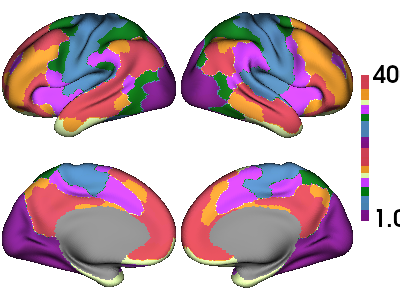

In [9]:
plot=atlas.copy()
plot[plot==0] = np.nan
fp.plot_surface(data=plot, size=(400,300), cmap=network_cmap, 
                color_range=(1,400), layout_style = 'grid',
                display=True, filename='./figures/atlas.png')

## Define eccentricity

In [10]:
def eccentricity(x,y,z):
    sum_xyz = pow(x,2) + pow(y,2) + pow(z,2)
    return pow(sum_xyz, 0.5)

## Group-level gradients & eccentricity    --    controls

In [11]:
gm = GradientMaps(approach='dm', kernel='normalized_angle', random_state=0)
gm.fit(fc_CTR.mean(0), sparsity=0.9)

GradientMaps(random_state=0)

/opt/miniconda3/envs/general/lib/python3.8/site-packages/brainspace/plotting/surface_plotting.py:437: RuntimeWarning: Running plot_hemispheres without a display may result in a crash. For a workaround please consult https://github.com/MICA-MNI/BrainSpace/issues/66. To suppress this warning set suppress_warnings=True.
  warnings.warn(


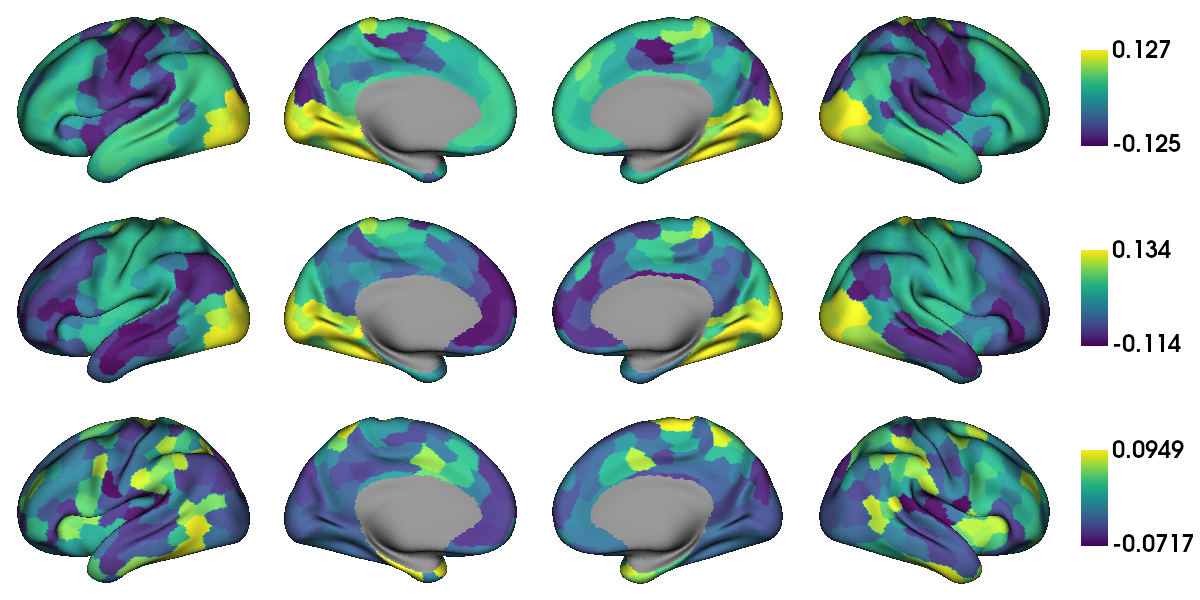

In [12]:
tmp=[gm.gradients_[:,0],gm.gradients_[:,1],gm.gradients_[:,2]]
plot = [None] * len(tmp)
for i in range(len(tmp)):
  plot[i] = atlas.copy()
  for j in range(400):
    plot[i][atlas==j+1] = tmp[i][j]
  plot[i][atlas==0] = np.nan

fp.plot_surface(data=plot, size=(1200,200*len(tmp)), cmap='viridis', #color_range=(-0.14,0.14),
                display=True, filename='./figures/CTR_G1-3.png') 

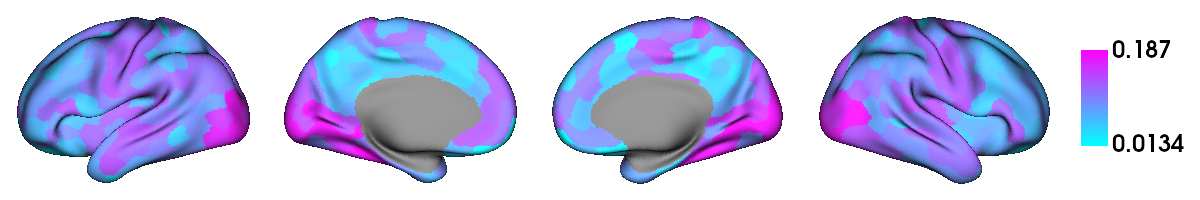

In [13]:
tmp = [eccentricity(gm.gradients_[:,0],gm.gradients_[:,1],gm.gradients_[:,2])]
plot = [None] * len(tmp)
for i in range(len(tmp)):
  plot[i] = atlas.copy()
  for j in range(400):
    plot[i][atlas==j+1] = tmp[i][j]
  plot[i][atlas==0] = np.nan

fp.plot_surface(data=plot, size=(1200,200*len(tmp)), cmap='cool', #color_range=(-0.14,0.14),
                display=True, filename='./figures/CTR_eccentricity.png') 

## Individual aligned and unaligned gradients

In [14]:
grad={}
eccen_unaligned={}
eccen_aligned={}
eccen_7={}
eccen_7u={}
for i in fc.keys():
    tmp = GradientMaps(approach='pca', kernel='normalized_angle', alignment='procrustes', random_state=0)
    grad[i] = tmp.fit(fc[i], sparsity=0.9, reference=gm.gradients_)
    eccen_aligned[i] = eccentricity(tmp.aligned_[:,0], tmp.aligned_[:,1], tmp.aligned_[:,2])
    eccen_unaligned[i] = eccentricity(tmp.gradients_[:,0], tmp.gradients_[:,1], tmp.gradients_[:,2])
    tmp7 = np.zeros(7)
    tmp7u = np.zeros(7)
    for j in range(7):
        tmp7[j] = eccen_aligned[i][network==j+1].mean()
        tmp7u[j] = eccen_unaligned[i][network==j+1].mean()
    eccen_7[i] = tmp7.copy()
    eccen_7u[i] = tmp7u.copy()

In [15]:
tmp_df = pd.DataFrame.from_dict(eccen_aligned, orient='index')
tmp_df.columns = ['node_' +str(i+1) for i in range(400)]
tmp_df = tmp_df.rename_axis('participant_id').reset_index()
tmp_df = pd.merge(demo, tmp_df, on='participant_id')
tmp_df['diagnosis'] = tmp_df['diagnosis'].astype('category')
tmp_df['diagnosis2'] = tmp_df['diagnosis2'].astype('category')
tmp_df['gender'] = tmp_df['gender'].astype('category')
tmp_df

participant_id diagnosis  age gender  bart  bht  dwi  pamenc  pamret  \
0        sub-10159         1   30      2   1.0  NaN  1.0     NaN     NaN   
1        sub-10189         1   49      1   1.0  NaN  1.0     NaN     NaN   
2        sub-10206         1   21      1   1.0  NaN  1.0     NaN     NaN   
3        sub-10217         1   33      2   1.0  NaN  1.0     NaN     NaN   
4        sub-10225         1   35      1   1.0  1.0  1.0     NaN     NaN   
..             ...       ...  ...    ...   ...  ...  ...     ...     ...   
182      sub-60079         3   33      1   1.0  1.0  1.0     1.0     1.0   
183      sub-60080         3   29      1   1.0  1.0  1.0     1.0     1.0   
184      sub-60084         3   32      2   1.0  1.0  1.0     1.0     1.0   
185      sub-60087         3   41      1   1.0  1.0  1.0     1.0     1.0   
186      sub-60089         3   29      2   1.0  1.0  1.0     1.0     1.0   

     rest  ...  node_391  node_392  node_393  node_394  node_395  node_396  \
0     1.0  ...  1.050890  0.980076  1.029305  1.088494  0.473949  0.396045   
1     1.0  ...  0.398852  0.204312  0.428131  0.303532  0.244853  0.430199   
2     1.0  ...  0.800925  0.688606  0.915110  0.630422  0.537769  0.489635   
3     1.0  ...  0.647412  0.393475  0.307468  1.158722  0.696794  0.213012   
4     1.0  ...  0.465049  0.766068  0.208961  0.504295  0.769855  0.575443   
..    ...  ...       ...       ...       ...       ...       ...       ...   
182   1.0  ...  0.457590  0.813871  0.431746  0.719977  0.678547  0.933483   
183   1.0  ...  0.669337  0.774474  0.517501  0.591982  0.433127  0.382667   
184   1.0  ...  0.660330  0.863769  0.391604  0.842449  0.863351  0.441566   
185   1.0  ...  0.392205  0.494071  0.520182  0.920243  0.542745  1.339424   
186   1.0  ...  0.397182  0.181786  0.112385  0.359156  0.358730  0.608877   

     node_397  node_398  node_399  node_400  
0    0.147144  0.204042  0.591088  0.394417  
1    0.512374  0.393599  0.429360  0.477074  
2    0.729350  1.073196  0.674046  0.526643  
3    0.688656  0.790522  0.299171  1.047026  
4    0.650031  0.866512  0.628808  0.634384  
..        ...       ...       ...       ...  
182  0.318550  0.295188  0.398690  0.719522  
183  0.579602  0.669650  0.798136  0.522609  
184  0.150156  0.380441  0.948599  0.437522  
185  0.532788  0.761906  1.160571  0.539262  
186  0.216206  0.670077  0.247518  0.310928  

[187 rows x 426 columns]

In [16]:
net_df = pd.DataFrame.from_dict(eccen_7, orient='index')
net_df.columns = ['net_' +str(i+1) for i in range(7)]
net_df = net_df.rename_axis('participant_id').reset_index()
net_df = pd.merge(demo, net_df, on='participant_id')
net_df['diagnosis'] = net_df['diagnosis'].astype('category')
net_df['diagnosis2'] = net_df['diagnosis2'].astype('category')
net_df['gender'] = net_df['gender'].astype('category')
net_df

participant_id diagnosis  age gender  bart  bht  dwi  pamenc  pamret  \
0        sub-10159         1   30      2   1.0  NaN  1.0     NaN     NaN   
1        sub-10189         1   49      1   1.0  NaN  1.0     NaN     NaN   
2        sub-10206         1   21      1   1.0  NaN  1.0     NaN     NaN   
3        sub-10217         1   33      2   1.0  NaN  1.0     NaN     NaN   
4        sub-10225         1   35      1   1.0  1.0  1.0     NaN     NaN   
..             ...       ...  ...    ...   ...  ...  ...     ...     ...   
182      sub-60079         3   33      1   1.0  1.0  1.0     1.0     1.0   
183      sub-60080         3   29      1   1.0  1.0  1.0     1.0     1.0   
184      sub-60084         3   32      2   1.0  1.0  1.0     1.0     1.0   
185      sub-60087         3   41      1   1.0  1.0  1.0     1.0     1.0   
186      sub-60089         3   29      2   1.0  1.0  1.0     1.0     1.0   

     rest  ...  SAPS disorganization  hamilton_21  \
0     1.0  ...                   NaN          NaN   
1     1.0  ...                   NaN          NaN   
2     1.0  ...                   NaN          NaN   
3     1.0  ...                   NaN          NaN   
4     1.0  ...                   NaN          NaN   
..    ...  ...                   ...          ...   
182   1.0  ...                   1.0         27.0   
183   1.0  ...                   3.0         33.0   
184   1.0  ...                   2.0         26.0   
185   1.0  ...                   3.0          4.0   
186   1.0  ...                   3.0         18.0   

     Risperidone equivalent dose     net_1     net_2     net_3     net_4  \
0                            NaN  1.241912  0.950853  0.894223  0.777284   
1                            NaN  0.913743  0.651938  0.558018  0.531824   
2                            NaN  1.141212  0.971976  1.043829  0.983422   
3                            NaN  1.313777  1.148157  0.968375  0.879376   
4                            NaN  0.989367  1.010083  0.875141  0.743497   
..                           ...       ...       ...       ...       ...   
182                         0.00  1.143903  0.882599  0.892033  0.818986   
183                         1.67  0.721385  0.608099  0.898376  0.755542   
184                        15.00  0.851905  0.785759  0.655600  0.686174   
185                         0.00  1.173316  1.271796  0.956912  0.849933   
186                         0.00  0.542580  0.583508  0.583511  0.603165   

        net_5     net_6     net_7  
0    0.528751  0.772157  0.815963  
1    0.548852  0.568574  0.565440  
2    0.706758  0.803093  1.085749  
3    0.688979  0.908427  0.834001  
4    0.741857  0.766830  0.768363  
..        ...       ...       ...  
182  0.661341  0.787506  0.965811  
183  0.575001  0.737250  0.799784  
184  0.756088  0.668691  0.628092  
185  0.780122  0.920478  0.878290  
186  0.671970  0.682632  0.595738  

[187 rows x 33 columns]

## Stats CTR vs BD+SCZ p < 0.01

/opt/miniconda3/envs/general/lib/python3.8/site-packages/brainspace/plotting/surface_plotting.py:437: RuntimeWarning: Running plot_hemispheres without a display may result in a crash. For a workaround please consult https://github.com/MICA-MNI/BrainSpace/issues/66. To suppress this warning set suppress_warnings=True.
  warnings.warn(


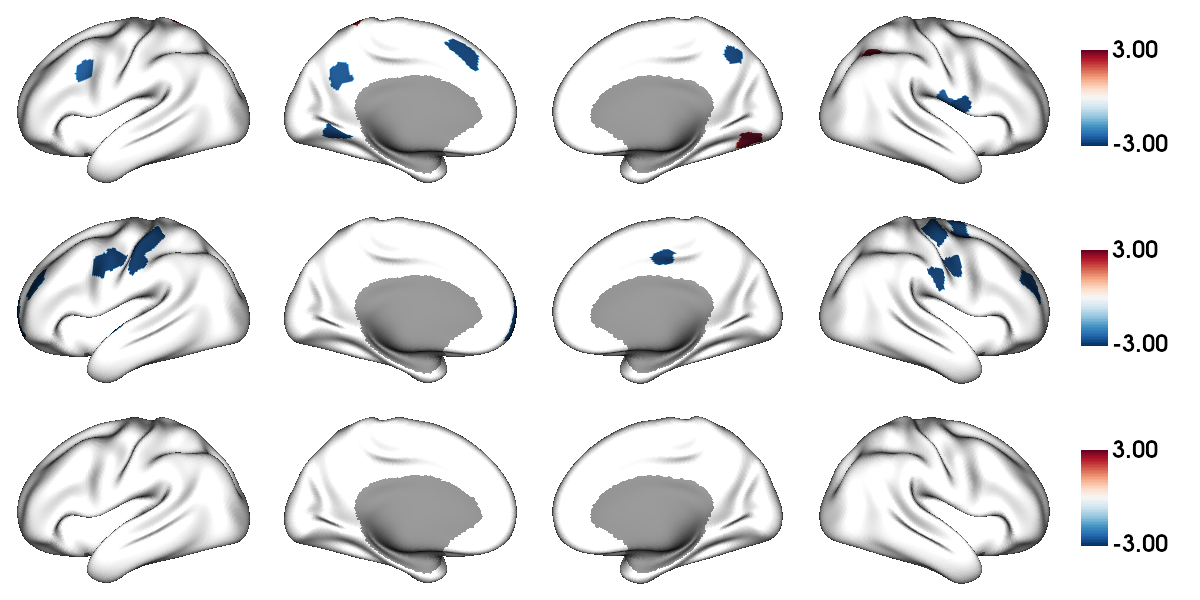

In [17]:
model = [None] * 400
for i in range(400):
  model[i] = smf.ols('node_'+str(i+1)+' ~ C(diagnosis2) + age + C(gender)', data=tmp_df).fit()
  # model[i] = OLS(tmp_df['node_'+str(i+1)], add_constant(tmp_df[['diagnosis2','age','gender']])).fit()

tmp = [np.array([model[i].tvalues['C(diagnosis2)[T.2]'] for i in range(400)]), 
       np.array([model[i].tvalues['age'] for i in range(400)]),
       np.array([model[i].tvalues['C(gender)[T.2]'] for i in range(400)])]

#tmp[0][fs.fdr(np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(400)]))>0.05] = 0
tmp[0][np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(400)])>0.01] = 0
tmp[1][fs.fdr(np.array([model[i].pvalues['age'] for i in range(400)]))>0.05] = 0
tmp[2][fs.fdr(np.array([model[i].pvalues['C(gender)[T.2]'] for i in range(400)]))>0.05] = 0

plot = [None] * len(tmp)
for i in range(len(tmp)):
  plot[i] = atlas.copy()
  for j in range(400):
    plot[i][atlas==j+1] = tmp[i][j]
  plot[i][atlas==0] = np.nan

fp.plot_surface(data=plot, size=(1200,200*len(tmp)), cmap='RdBu_r', color_range=(-3,3),
                display=True, filename='./figures/eccentricity_aligned_2groups_t.png')

In [18]:
model = [None] * 7
for i in range(7):
  model[i] = smf.ols('net_'+str(i+1)+' ~ C(diagnosis2) + age + C(gender)', data=net_df).fit()

tmp = [np.array([model[i].tvalues['C(diagnosis2)[T.2]'] for i in range(7)]), 
       np.array([model[i].tvalues['age'] for i in range(7)]),
       np.array([model[i].tvalues['C(gender)[T.2]'] for i in range(7)])]

#tmp[0][fs.fdr(np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(7)]))>0.05] = 0
#tmp[0][np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(7)])>0.01] = 0
#tmp[1][fs.fdr(np.array([model[i].pvalues['age'] for i in range(7)]))>0.05] = 0
#tmp[2][fs.fdr(np.array([model[i].pvalues['C(gender)[T.2]'] for i in range(7)]))>0.05] = 0
sts = pd.DataFrame()
sts['Network'] = net_name
sts['tvalue'] = np.array([model[i].tvalues['C(diagnosis2)[T.2]'] for i in range(7)])
sts['pvalue'] = np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(7)])
sts['pvalue_fdr'] = fs.fdr(np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(7)]))
sts.style.set_caption("CTR vs BD+SCZ")

In [19]:
sts = pd.DataFrame()
sts['Network'] = net_name
tmp = np.array([fs.pearson_na(net_df.hamilton_21, net_df['net_'+str(i+1)]) for i in range(7)])
sts['N'] = tmp[:,2].astype(int)
sts['Pearson r'] = tmp[:,0]
sts['pvalue'] = tmp[:,1]
sts.style.set_caption("hamilton_21")

In [20]:
sts = pd.DataFrame()
sts['Network'] = net_name
tmp = np.array([fs.pearson_na(net_df['SAPS Positive Symptoms'], net_df['net_'+str(i+1)]) for i in range(7)])
sts['N'] = tmp[:,2].astype(int)
sts['Pearson r'] = tmp[:,0]
sts['pvalue'] = tmp[:,1]
sts.style.set_caption("SAPS Positive Symptoms")

In [21]:
sts = pd.DataFrame()
sts['Network'] = net_name
tmp = np.array([fs.pearson_na(net_df['SAPS disorganization'], net_df['net_'+str(i+1)]) for i in range(7)])
sts['N'] = tmp[:,2].astype(int)
sts['Pearson r'] = tmp[:,0]
sts['pvalue'] = tmp[:,1]
sts.style.set_caption("SAPS disorganization")

In [22]:
sts = pd.DataFrame()
sts['Network'] = net_name
tmp = np.array([fs.pearson_na(net_df['Amotivation'], net_df['net_'+str(i+1)]) for i in range(7)])
sts['N'] = tmp[:,2].astype(int)
sts['Pearson r'] = tmp[:,0]
sts['pvalue'] = tmp[:,1]
sts.style.set_caption("Amotivation")

In [23]:
sts = pd.DataFrame()
sts['Network'] = net_name
tmp = np.array([fs.pearson_na(net_df['DimEx'], net_df['net_'+str(i+1)]) for i in range(7)])
sts['N'] = tmp[:,2].astype(int)
sts['Pearson r'] = tmp[:,0]
sts['pvalue'] = tmp[:,1]
sts.style.set_caption("DimEx")

## Stats CTR vs BD vs SCZ p < 0.01

### SCZ

/opt/miniconda3/envs/general/lib/python3.8/site-packages/brainspace/plotting/surface_plotting.py:437: RuntimeWarning: Running plot_hemispheres without a display may result in a crash. For a workaround please consult https://github.com/MICA-MNI/BrainSpace/issues/66. To suppress this warning set suppress_warnings=True.
  warnings.warn(


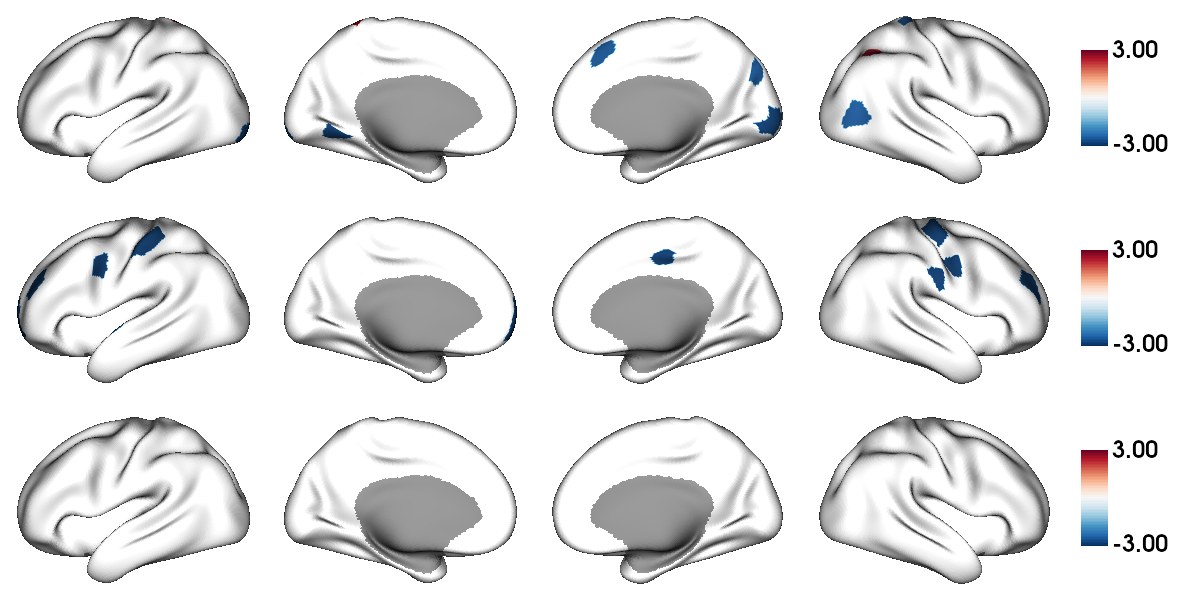

In [24]:
model = [None] * 400
for i in range(400):
  model[i] = smf.ols('node_'+str(i+1)+' ~ C(diagnosis) + age + C(gender)', data=tmp_df).fit()
  # model[i] = OLS(tmp_df['node_'+str(i+1)], add_constant(tmp_df[['diagnosis2','age','gender']])).fit()

tmp = [np.array([model[i].tvalues['C(diagnosis)[T.2]'] for i in range(400)]), 
       np.array([model[i].tvalues['age'] for i in range(400)]),
       np.array([model[i].tvalues['C(gender)[T.2]'] for i in range(400)])]

#tmp[0][fs.fdr(np.array([model[i].pvalues['C(diagnosis)[T.2]'] for i in range(400)]))>0.05] = 0
tmp[0][np.array([model[i].pvalues['C(diagnosis)[T.2]'] for i in range(400)])>0.01] = 0
tmp[1][fs.fdr(np.array([model[i].pvalues['age'] for i in range(400)]))>0.05] = 0
tmp[2][fs.fdr(np.array([model[i].pvalues['C(gender)[T.2]'] for i in range(400)]))>0.05] = 0

plot = [None] * len(tmp)
for i in range(len(tmp)):
  plot[i] = atlas.copy()
  for j in range(400):
    plot[i][atlas==j+1] = tmp[i][j]
  plot[i][atlas==0] = np.nan

fp.plot_surface(data=plot, size=(1200,200*len(tmp)), cmap='RdBu_r', color_range=(-3,3),
                display=True, filename='./figures/eccentricity_aligned_3groups_SCZ_t.png')

In [25]:
model = [None] * 7
for i in range(7):
  model[i] = smf.ols('net_'+str(i+1)+' ~ C(diagnosis) + age + C(gender)', data=net_df).fit()

tmp = [np.array([model[i].tvalues['C(diagnosis)[T.2]'] for i in range(7)]), 
       np.array([model[i].tvalues['age'] for i in range(7)]),
       np.array([model[i].tvalues['C(gender)[T.2]'] for i in range(7)])]

#tmp[0][fs.fdr(np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(7)]))>0.05] = 0
#tmp[0][np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(7)])>0.01] = 0
#tmp[1][fs.fdr(np.array([model[i].pvalues['age'] for i in range(7)]))>0.05] = 0
#tmp[2][fs.fdr(np.array([model[i].pvalues['C(gender)[T.2]'] for i in range(7)]))>0.05] = 0

sts = pd.DataFrame()
sts['Network'] = net_name
sts['tvalue'] = np.array([model[i].tvalues['C(diagnosis)[T.2]'] for i in range(7)])
sts['pvalue'] = np.array([model[i].pvalues['C(diagnosis)[T.2]'] for i in range(7)])
sts['pvalue_fdr'] = fs.fdr(np.array([model[i].pvalues['C(diagnosis)[T.2]'] for i in range(7)]))
sts.style.set_caption("CTR vs SCZ")

### BD

In [26]:
model[0].tvalues['C(diagnosis)[T.3]']

0.07254244140969497

/opt/miniconda3/envs/general/lib/python3.8/site-packages/brainspace/plotting/surface_plotting.py:437: RuntimeWarning: Running plot_hemispheres without a display may result in a crash. For a workaround please consult https://github.com/MICA-MNI/BrainSpace/issues/66. To suppress this warning set suppress_warnings=True.
  warnings.warn(


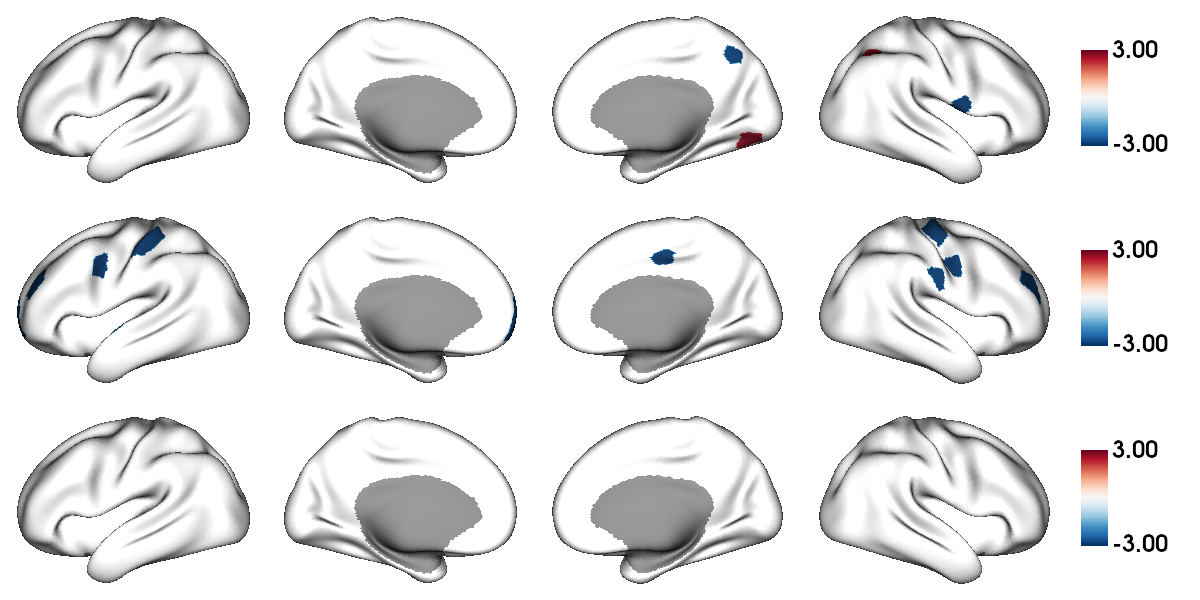

In [27]:
model = [None] * 400
for i in range(400):
  model[i] = smf.ols('node_'+str(i+1)+' ~ C(diagnosis) + age + C(gender)', data=tmp_df).fit()
  # model[i] = OLS(tmp_df['node_'+str(i+1)], add_constant(tmp_df[['diagnosis2','age','gender']])).fit()
  
tmp = [np.array([model[i].tvalues['C(diagnosis)[T.3]'] for i in range(400)]), 
       np.array([model[i].tvalues['age'] for i in range(400)]),
       np.array([model[i].tvalues['C(gender)[T.2]'] for i in range(400)])]

#tmp[0][fs.fdr(np.array([model[i].pvalues['C(diagnosis)[T.3]'] for i in range(400)]))>0.05] = 0
tmp[0][np.array([model[i].pvalues['C(diagnosis)[T.3]'] for i in range(400)])>0.01] = 0
tmp[1][fs.fdr(np.array([model[i].pvalues['age'] for i in range(400)]))>0.05] = 0
tmp[2][fs.fdr(np.array([model[i].pvalues['C(gender)[T.2]'] for i in range(400)]))>0.05] = 0

plot = [None] * len(tmp)
for i in range(len(tmp)):
  plot[i] = atlas.copy()
  for j in range(400):
    plot[i][atlas==j+1] = tmp[i][j]
  plot[i][atlas==0] = np.nan

fp.plot_surface(data=plot, size=(1200,200*len(tmp)), cmap='RdBu_r', color_range=(-3,3),
                display=True, filename='./figures/eccentricity_aligned_3groups_BD_t.png')

In [28]:
model = [None] * 7
for i in range(7):
  model[i] = smf.ols('net_'+str(i+1)+' ~ C(diagnosis) + age + C(gender)', data=net_df).fit()

tmp = [np.array([model[i].tvalues['C(diagnosis)[T.3]'] for i in range(7)]), 
       np.array([model[i].tvalues['age'] for i in range(7)]),
       np.array([model[i].tvalues['C(gender)[T.2]'] for i in range(7)])]

#tmp[0][fs.fdr(np.array([model[i].pvalues['C(diagnosis)[T.3]'] for i in range(7)]))>0.05] = 0
#tmp[0][np.array([model[i].pvalues['C(diagnosis)[T.3]'] for i in range(7)])>0.01] = 0
#tmp[1][fs.fdr(np.array([model[i].pvalues['age'] for i in range(7)]))>0.05] = 0
#tmp[2][fs.fdr(np.array([model[i].pvalues['C(gender)[T.2]'] for i in range(7)]))>0.05] = 0

sts = pd.DataFrame()
sts['Network'] = net_name
sts['tvalue'] = np.array([model[i].tvalues['C(diagnosis)[T.3]'] for i in range(7)])
sts['pvalue'] = np.array([model[i].pvalues['C(diagnosis)[T.3]'] for i in range(7)])
sts['pvalue_fdr'] = fs.fdr(np.array([model[i].pvalues['C(diagnosis)[T.3]'] for i in range(7)]))
sts.style.set_caption("CTR vs SCZ")

## G1: p<0.01

In [29]:
g_n=0 #g1
g_name =str(g_n+1)
g = {}
g_net = {}
for i in grad.keys():
    g[i] = grad.get(i).aligned_[:,g_n] # change number here
    g_net[i] = np.zeros(7)
    for j in range(7):
        g_net[i][j] = grad.get(i).aligned_[network==j+1,g_n].mean()
tmp_df = pd.DataFrame.from_dict(g, orient='index')
tmp_df.columns = ['node_' +str(i+1) for i in range(400)]
tmp_df = tmp_df.rename_axis('participant_id').reset_index()
tmp_df = pd.merge(demo, tmp_df, on='participant_id')
tmp_df['diagnosis'] = tmp_df['diagnosis'].astype('category')
tmp_df['diagnosis2'] = tmp_df['diagnosis2'].astype('category')
tmp_df['gender'] = tmp_df['gender'].astype('category')
tmp_df

participant_id diagnosis  age gender  bart  bht  dwi  pamenc  pamret  \
0        sub-10159         1   30      2   1.0  NaN  1.0     NaN     NaN   
1        sub-10189         1   49      1   1.0  NaN  1.0     NaN     NaN   
2        sub-10206         1   21      1   1.0  NaN  1.0     NaN     NaN   
3        sub-10217         1   33      2   1.0  NaN  1.0     NaN     NaN   
4        sub-10225         1   35      1   1.0  1.0  1.0     NaN     NaN   
..             ...       ...  ...    ...   ...  ...  ...     ...     ...   
182      sub-60079         3   33      1   1.0  1.0  1.0     1.0     1.0   
183      sub-60080         3   29      1   1.0  1.0  1.0     1.0     1.0   
184      sub-60084         3   32      2   1.0  1.0  1.0     1.0     1.0   
185      sub-60087         3   41      1   1.0  1.0  1.0     1.0     1.0   
186      sub-60089         3   29      2   1.0  1.0  1.0     1.0     1.0   

     rest  ...  node_391  node_392  node_393  node_394  node_395  node_396  \
0     1.0  ...  0.292920  0.333369  0.276171  0.285739  0.272818  0.377732   
1     1.0  ...  0.004103  0.102285 -0.248851 -0.114663 -0.150832  0.393225   
2     1.0  ...  0.196779  0.197845  0.211380  0.375482  0.201203  0.188247   
3     1.0  ... -0.273426  0.183207 -0.235472 -0.611784 -0.415476  0.125215   
4     1.0  ...  0.325809  0.409050 -0.054220 -0.192589  0.359481  0.320425   
..    ...  ...       ...       ...       ...       ...       ...       ...   
182   1.0  ... -0.188131  0.137725 -0.315994 -0.018071  0.058164  0.299611   
183   1.0  ...  0.162771  0.355078  0.076547 -0.007705 -0.098955 -0.151962   
184   1.0  ...  0.453724  0.344465  0.190996  0.198582  0.654367 -0.399762   
185   1.0  ... -0.128121  0.287098  0.015418 -0.467137  0.225031  0.535921   
186   1.0  ... -0.311106  0.037569 -0.031339  0.069354 -0.248083 -0.418704   

     node_397  node_398  node_399  node_400  
0    0.136337 -0.019924  0.321693  0.357974  
1    0.364968  0.268738  0.387203 -0.176869  
2    0.443375  0.599798  0.403784  0.237605  
3    0.406308 -0.521741  0.075927  0.283767  
4   -0.430043 -0.435107  0.129216 -0.188606  
..        ...       ...       ...       ...  
182 -0.263665  0.044844 -0.277901 -0.440958  
183 -0.311694  0.572866 -0.534422 -0.479973  
184 -0.145482 -0.136822  0.073583  0.256587  
185  0.236205 -0.263453  0.497333  0.186426  
186 -0.150789 -0.356252  0.212525 -0.157543  

[187 rows x 426 columns]

In [30]:
net_df = pd.DataFrame.from_dict(g_net, orient='index')
net_df.columns = ['net_' +str(i+1) for i in range(7)]
net_df = net_df.rename_axis('participant_id').reset_index()
net_df = pd.merge(demo, net_df, on='participant_id')
net_df['diagnosis'] = net_df['diagnosis'].astype('category')
net_df['diagnosis2'] = net_df['diagnosis2'].astype('category')
net_df['gender'] = net_df['gender'].astype('category')
net_df

participant_id diagnosis  age gender  bart  bht  dwi  pamenc  pamret  \
0        sub-10159         1   30      2   1.0  NaN  1.0     NaN     NaN   
1        sub-10189         1   49      1   1.0  NaN  1.0     NaN     NaN   
2        sub-10206         1   21      1   1.0  NaN  1.0     NaN     NaN   
3        sub-10217         1   33      2   1.0  NaN  1.0     NaN     NaN   
4        sub-10225         1   35      1   1.0  1.0  1.0     NaN     NaN   
..             ...       ...  ...    ...   ...  ...  ...     ...     ...   
182      sub-60079         3   33      1   1.0  1.0  1.0     1.0     1.0   
183      sub-60080         3   29      1   1.0  1.0  1.0     1.0     1.0   
184      sub-60084         3   32      2   1.0  1.0  1.0     1.0     1.0   
185      sub-60087         3   41      1   1.0  1.0  1.0     1.0     1.0   
186      sub-60089         3   29      2   1.0  1.0  1.0     1.0     1.0   

     rest  ...  SAPS disorganization  hamilton_21  \
0     1.0  ...                   NaN          NaN   
1     1.0  ...                   NaN          NaN   
2     1.0  ...                   NaN          NaN   
3     1.0  ...                   NaN          NaN   
4     1.0  ...                   NaN          NaN   
..    ...  ...                   ...          ...   
182   1.0  ...                   1.0         27.0   
183   1.0  ...                   3.0         33.0   
184   1.0  ...                   2.0         26.0   
185   1.0  ...                   3.0          4.0   
186   1.0  ...                   3.0         18.0   

     Risperidone equivalent dose     net_1     net_2     net_3     net_4  \
0                            NaN  0.350004 -0.296732 -0.357744 -0.423916   
1                            NaN  0.384091 -0.251092 -0.187685 -0.170135   
2                            NaN  0.408659 -0.216790 -0.566394 -0.469547   
3                            NaN  0.395015 -0.414185 -0.354880 -0.137251   
4                            NaN  0.135323 -0.544373 -0.343991 -0.063476   
..                           ...       ...       ...       ...       ...   
182                         0.00  0.527445 -0.358184 -0.351113 -0.368246   
183                         1.67  0.285278 -0.242291 -0.600802 -0.367798   
184                        15.00  0.256675 -0.289956 -0.142308 -0.119808   
185                         0.00  0.147796 -0.663462 -0.264384 -0.190688   
186                         0.00 -0.022126 -0.182614 -0.119552 -0.142745   

        net_5     net_6     net_7  
0    0.131583  0.155920  0.289554  
1   -0.032226  0.122632  0.076872  
2    0.007094  0.158375  0.345797  
3    0.125790  0.246233  0.159307  
4    0.245471  0.320800  0.323133  
..        ...       ...       ...  
182 -0.110755  0.120390  0.280045  
183 -0.023606  0.337881  0.321119  
184  0.146408  0.090564  0.113524  
185  0.366751  0.398138  0.362158  
186  0.272532  0.261906  0.075983  

[187 rows x 33 columns]

/opt/miniconda3/envs/general/lib/python3.8/site-packages/brainspace/plotting/surface_plotting.py:437: RuntimeWarning: Running plot_hemispheres without a display may result in a crash. For a workaround please consult https://github.com/MICA-MNI/BrainSpace/issues/66. To suppress this warning set suppress_warnings=True.
  warnings.warn(


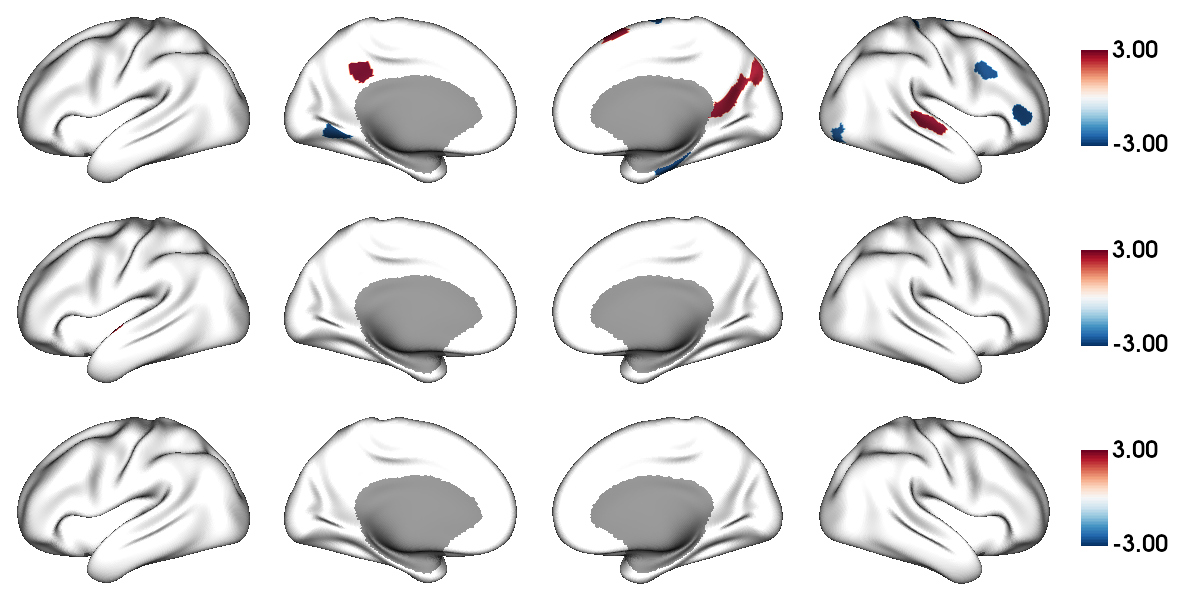

In [31]:
model = [None] * 400
for i in range(400):
  model[i] = smf.ols('node_'+str(i+1)+' ~ C(diagnosis2) + age + C(gender)', data=tmp_df).fit()
  # model[i] = OLS(tmp_df['node_'+str(i+1)], add_constant(tmp_df[['diagnosis2','age','gender']])).fit()

tmp = [np.array([model[i].tvalues['C(diagnosis2)[T.2]'] for i in range(400)]), 
       np.array([model[i].tvalues['age'] for i in range(400)]),
       np.array([model[i].tvalues['C(gender)[T.2]'] for i in range(400)])]

#tmp[0][fs.fdr(np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(400)]))>0.05] = 0
tmp[0][np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(400)]) > 0.01] = 0
tmp[1][fs.fdr(np.array([model[i].pvalues['age'] for i in range(400)]))>0.05] = 0
tmp[2][fs.fdr(np.array([model[i].pvalues['C(gender)[T.2]'] for i in range(400)]))>0.05] = 0

plot = [None] * len(tmp)
for i in range(len(tmp)):
  plot[i] = atlas.copy()
  for j in range(400):
    plot[i][atlas==j+1] = tmp[i][j]
  plot[i][atlas==0] = np.nan

fp.plot_surface(data=plot, size=(1200,200*len(tmp)), cmap='RdBu_r', color_range=(-3,3),
                display=True, filename='./figures/'+g_name+'_aligned_2groups_t.png')

In [32]:
model = [None] * 7
for i in range(7):
  model[i] = smf.ols('net_'+str(i+1)+' ~ C(diagnosis2) + age + C(gender)', data=net_df).fit()

tmp = [np.array([model[i].tvalues['C(diagnosis2)[T.2]'] for i in range(7)]), 
       np.array([model[i].tvalues['age'] for i in range(7)]),
       np.array([model[i].tvalues['C(gender)[T.2]'] for i in range(7)])]

#tmp[0][fs.fdr(np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(7)]))>0.05] = 0
#tmp[0][np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(7)])>0.01] = 0
#tmp[1][fs.fdr(np.array([model[i].pvalues['age'] for i in range(7)]))>0.05] = 0
#tmp[2][fs.fdr(np.array([model[i].pvalues['C(gender)[T.2]'] for i in range(7)]))>0.05] = 0
sts = pd.DataFrame()
sts['Network'] = net_name
sts['tvalue'] = np.array([model[i].tvalues['C(diagnosis2)[T.2]'] for i in range(7)])
sts['pvalue'] = np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(7)])
sts['pvalue_fdr'] = fs.fdr(np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(7)]))
sts.style.set_caption('G' + g_name+': CTR vs BD+SCZ')

In [33]:
sts = pd.DataFrame()
sts['Network'] = net_name
tmp = np.array([fs.pearson_na(net_df.hamilton_21, net_df['net_'+str(i+1)]) for i in range(7)])
sts['N'] = tmp[:,2].astype(int)
sts['Pearson r'] = tmp[:,0]
sts['pvalue'] = tmp[:,1]
sts.style.set_caption("hamilton_21")

In [34]:
sts = pd.DataFrame()
sts['Network'] = net_name
tmp = np.array([fs.pearson_na(net_df['SAPS Positive Symptoms'], net_df['net_'+str(i+1)]) for i in range(7)])
sts['N'] = tmp[:,2].astype(int)
sts['Pearson r'] = tmp[:,0]
sts['pvalue'] = tmp[:,1]
sts.style.set_caption("SAPS Positive Symptoms")

In [35]:
sts = pd.DataFrame()
sts['Network'] = net_name
tmp = np.array([fs.pearson_na(net_df['SAPS disorganization'], net_df['net_'+str(i+1)]) for i in range(7)])
sts['N'] = tmp[:,2].astype(int)
sts['Pearson r'] = tmp[:,0]
sts['pvalue'] = tmp[:,1]
sts.style.set_caption("SAPS disorganization")

In [36]:
sts = pd.DataFrame()
sts['Network'] = net_name
tmp = np.array([fs.pearson_na(net_df['Amotivation'], net_df['net_'+str(i+1)]) for i in range(7)])
sts['N'] = tmp[:,2].astype(int)
sts['Pearson r'] = tmp[:,0]
sts['pvalue'] = tmp[:,1]
sts.style.set_caption("Amotivation")

In [37]:
sts = pd.DataFrame()
sts['Network'] = net_name
tmp = np.array([fs.pearson_na(net_df['DimEx'], net_df['net_'+str(i+1)]) for i in range(7)])
sts['N'] = tmp[:,2].astype(int)
sts['Pearson r'] = tmp[:,0]
sts['pvalue'] = tmp[:,1]
sts.style.set_caption("DimEx")

/opt/miniconda3/envs/general/lib/python3.8/site-packages/brainspace/plotting/surface_plotting.py:437: RuntimeWarning: Running plot_hemispheres without a display may result in a crash. For a workaround please consult https://github.com/MICA-MNI/BrainSpace/issues/66. To suppress this warning set suppress_warnings=True.
  warnings.warn(


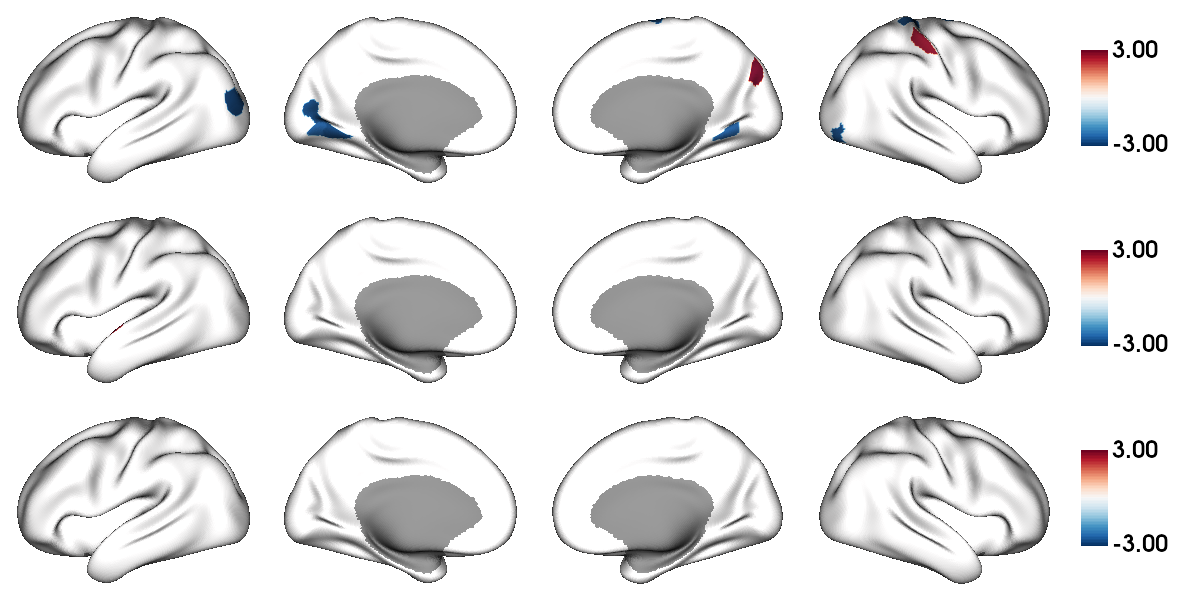

In [38]:
model = [None] * 400
for i in range(400):
  model[i] = smf.ols('node_'+str(i+1)+' ~ C(diagnosis) + age + C(gender)', data=tmp_df).fit()
  # model[i] = OLS(tmp_df['node_'+str(i+1)], add_constant(tmp_df[['diagnosis2','age','gender']])).fit()

tmp = [np.array([model[i].tvalues['C(diagnosis)[T.2]'] for i in range(400)]), 
       np.array([model[i].tvalues['age'] for i in range(400)]),
       np.array([model[i].tvalues['C(gender)[T.2]'] for i in range(400)])]

#tmp[0][fs.fdr(np.array([model[i].pvalues['C(diagnosis)[T.2]'] for i in range(400)]))>0.05] = 0
tmp[0][np.array([model[i].pvalues['C(diagnosis)[T.2]'] for i in range(400)])>0.01] = 0
tmp[1][fs.fdr(np.array([model[i].pvalues['age'] for i in range(400)]))>0.05] = 0
tmp[2][fs.fdr(np.array([model[i].pvalues['C(gender)[T.2]'] for i in range(400)]))>0.05] = 0

plot = [None] * len(tmp)
for i in range(len(tmp)):
  plot[i] = atlas.copy()
  for j in range(400):
    plot[i][atlas==j+1] = tmp[i][j]
  plot[i][atlas==0] = np.nan

fp.plot_surface(data=plot, size=(1200,200*len(tmp)), cmap='RdBu_r', color_range=(-3,3),
                display=True, filename='./figures/'+g_name+'_aligned_3groups_SCZ_t.png')

In [39]:
model = [None] * 7
for i in range(7):
  model[i] = smf.ols('net_'+str(i+1)+' ~ C(diagnosis) + age + C(gender)', data=net_df).fit()

tmp = [np.array([model[i].tvalues['C(diagnosis)[T.2]'] for i in range(7)]), 
       np.array([model[i].tvalues['age'] for i in range(7)]),
       np.array([model[i].tvalues['C(gender)[T.2]'] for i in range(7)])]

#tmp[0][fs.fdr(np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(7)]))>0.05] = 0
#tmp[0][np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(7)])>0.01] = 0
#tmp[1][fs.fdr(np.array([model[i].pvalues['age'] for i in range(7)]))>0.05] = 0
#tmp[2][fs.fdr(np.array([model[i].pvalues['C(gender)[T.2]'] for i in range(7)]))>0.05] = 0

sts = pd.DataFrame()
sts['Network'] = net_name
sts['tvalue'] = np.array([model[i].tvalues['C(diagnosis)[T.2]'] for i in range(7)])
sts['pvalue'] = np.array([model[i].pvalues['C(diagnosis)[T.2]'] for i in range(7)])
sts['pvalue_fdr'] = fs.fdr(np.array([model[i].pvalues['C(diagnosis)[T.2]'] for i in range(7)]))
sts.style.set_caption("CTR vs SCZ")

/opt/miniconda3/envs/general/lib/python3.8/site-packages/brainspace/plotting/surface_plotting.py:437: RuntimeWarning: Running plot_hemispheres without a display may result in a crash. For a workaround please consult https://github.com/MICA-MNI/BrainSpace/issues/66. To suppress this warning set suppress_warnings=True.
  warnings.warn(


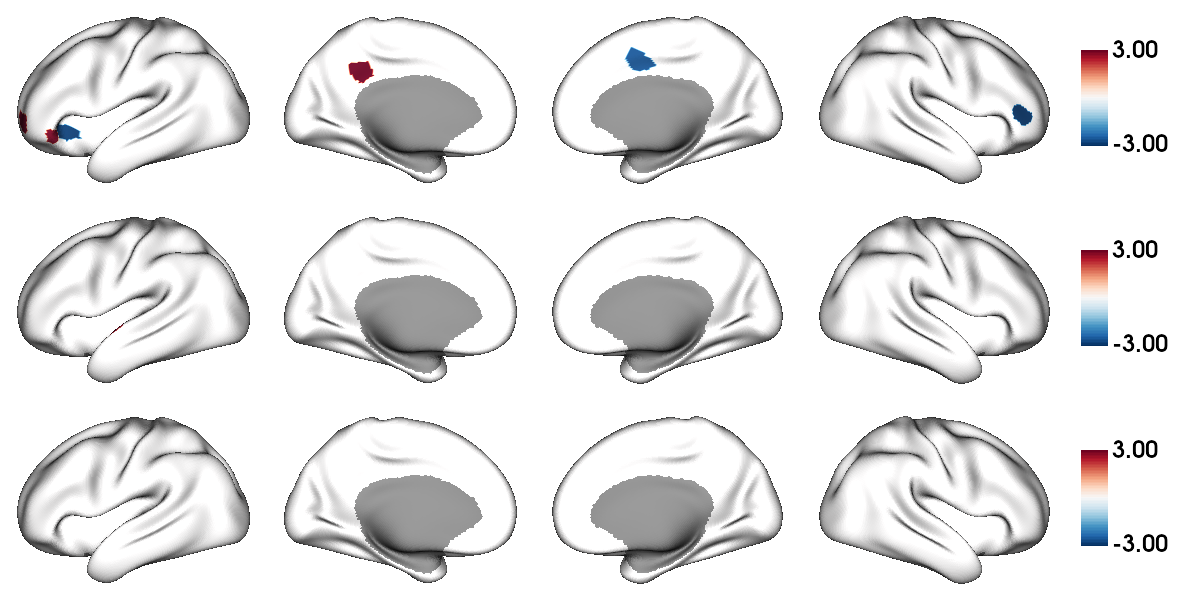

In [40]:
model = [None] * 400
for i in range(400):
  model[i] = smf.ols('node_'+str(i+1)+' ~ C(diagnosis) + age + C(gender)', data=tmp_df).fit()
  # model[i] = OLS(tmp_df['node_'+str(i+1)], add_constant(tmp_df[['diagnosis2','age','gender']])).fit()

tmp = [np.array([model[i].tvalues['C(diagnosis)[T.3]'] for i in range(400)]), 
       np.array([model[i].tvalues['age'] for i in range(400)]),
       np.array([model[i].tvalues['C(gender)[T.2]'] for i in range(400)])]

#tmp[0][fs.fdr(np.array([model[i].pvalues['C(diagnosis)[T.3]'] for i in range(400)]))>0.05] = 0
tmp[0][np.array([model[i].pvalues['C(diagnosis)[T.3]'] for i in range(400)])>0.01] = 0
tmp[1][fs.fdr(np.array([model[i].pvalues['age'] for i in range(400)]))>0.05] = 0
tmp[2][fs.fdr(np.array([model[i].pvalues['C(gender)[T.2]'] for i in range(400)]))>0.05] = 0

plot = [None] * len(tmp)
for i in range(len(tmp)):
  plot[i] = atlas.copy()
  for j in range(400):
    plot[i][atlas==j+1] = tmp[i][j]
  plot[i][atlas==0] = np.nan

fp.plot_surface(data=plot, size=(1200,200*len(tmp)), cmap='RdBu_r', color_range=(-3,3),
                display=True, filename='./figures/'+g_name+'_aligned_3groups_BD_t.png')

In [41]:
model = [None] * 7
for i in range(7):
  model[i] = smf.ols('net_'+str(i+1)+' ~ C(diagnosis) + age + C(gender)', data=net_df).fit()

tmp = [np.array([model[i].tvalues['C(diagnosis)[T.3]'] for i in range(7)]), 
       np.array([model[i].tvalues['age'] for i in range(7)]),
       np.array([model[i].tvalues['C(gender)[T.2]'] for i in range(7)])]

sts = pd.DataFrame()
sts['Network'] = net_name
sts['tvalue'] = np.array([model[i].tvalues['C(diagnosis)[T.3]'] for i in range(7)])
sts['pvalue'] = np.array([model[i].pvalues['C(diagnosis)[T.3]'] for i in range(7)])
sts['pvalue_fdr'] = fs.fdr(np.array([model[i].pvalues['C(diagnosis)[T.3]'] for i in range(7)]))
sts.style.set_caption("CTR vs BD")

## G2: p<0.01

In [42]:
g_n=1 #g2
g_name =str(g_n+1)
g = {}
g_net = {}
for i in grad.keys():
    g[i] = grad.get(i).aligned_[:,g_n] # change number here
    g_net[i] = np.zeros(7)
    for j in range(7):
        g_net[i][j] = grad.get(i).aligned_[network==j+1,g_n].mean()
tmp_df = pd.DataFrame.from_dict(g, orient='index')
tmp_df.columns = ['node_' +str(i+1) for i in range(400)]
tmp_df = tmp_df.rename_axis('participant_id').reset_index()
tmp_df = pd.merge(demo, tmp_df, on='participant_id')
tmp_df['diagnosis'] = tmp_df['diagnosis'].astype('category')
tmp_df['diagnosis2'] = tmp_df['diagnosis2'].astype('category')
tmp_df['gender'] = tmp_df['gender'].astype('category')
tmp_df

participant_id diagnosis  age gender  bart  bht  dwi  pamenc  pamret  \
0        sub-10159         1   30      2   1.0  NaN  1.0     NaN     NaN   
1        sub-10189         1   49      1   1.0  NaN  1.0     NaN     NaN   
2        sub-10206         1   21      1   1.0  NaN  1.0     NaN     NaN   
3        sub-10217         1   33      2   1.0  NaN  1.0     NaN     NaN   
4        sub-10225         1   35      1   1.0  1.0  1.0     NaN     NaN   
..             ...       ...  ...    ...   ...  ...  ...     ...     ...   
182      sub-60079         3   33      1   1.0  1.0  1.0     1.0     1.0   
183      sub-60080         3   29      1   1.0  1.0  1.0     1.0     1.0   
184      sub-60084         3   32      2   1.0  1.0  1.0     1.0     1.0   
185      sub-60087         3   41      1   1.0  1.0  1.0     1.0     1.0   
186      sub-60089         3   29      2   1.0  1.0  1.0     1.0     1.0   

     rest  ...  node_391  node_392  node_393  node_394  node_395  node_396  \
0     1.0  ... -0.936217 -0.863162 -0.920577 -0.979296 -0.362086  0.067009   
1     1.0  ... -0.025137 -0.037280 -0.076939 -0.226542  0.164010  0.094254   
2     1.0  ... -0.647750 -0.464129 -0.777748  0.265549 -0.242785 -0.213991   
3     1.0  ...  0.052082 -0.175358 -0.081166  0.580319  0.321919  0.170808   
4     1.0  ... -0.004865 -0.563457  0.103404  0.053180 -0.668622 -0.441912   
..    ...  ...       ...       ...       ...       ...       ...       ...   
182   1.0  ... -0.367780 -0.722031 -0.293929 -0.579798 -0.572042 -0.816635   
183   1.0  ... -0.301494 -0.369782 -0.384720  0.010053  0.028516 -0.012709   
184   1.0  ... -0.192604 -0.243871 -0.063094 -0.200114  0.088509 -0.138550   
185   1.0  ...  0.108360 -0.203611  0.393245  0.765029 -0.435260 -1.152772   
186   1.0  ...  0.168783 -0.032911 -0.106263  0.019217 -0.214181  0.339490   

     node_397  node_398  node_399  node_400  
0    0.040142 -0.181596 -0.481891  0.130463  
1    0.280336  0.286045 -0.023967  0.047117  
2    0.577468  0.809867  0.476440 -0.088024  
3    0.528503  0.378038 -0.153567 -0.920168  
4    0.065053  0.587692 -0.233762 -0.025998  
..        ...       ...       ...       ...  
182  0.176669  0.212484 -0.120583  0.046616  
183  0.111517  0.269953  0.315364  0.105746  
184  0.011504 -0.260966 -0.539461 -0.121597  
185 -0.438498  0.712603 -1.029854  0.017164  
186  0.154470  0.551121  0.094982  0.211481  

[187 rows x 426 columns]

In [43]:
net_df = pd.DataFrame.from_dict(g_net, orient='index')
net_df.columns = ['net_' +str(i+1) for i in range(7)]
net_df = net_df.rename_axis('participant_id').reset_index()
net_df = pd.merge(demo, net_df, on='participant_id')
net_df['diagnosis'] = net_df['diagnosis'].astype('category')
net_df['diagnosis2'] = net_df['diagnosis2'].astype('category')
net_df['gender'] = net_df['gender'].astype('category')
net_df

participant_id diagnosis  age gender  bart  bht  dwi  pamenc  pamret  \
0        sub-10159         1   30      2   1.0  NaN  1.0     NaN     NaN   
1        sub-10189         1   49      1   1.0  NaN  1.0     NaN     NaN   
2        sub-10206         1   21      1   1.0  NaN  1.0     NaN     NaN   
3        sub-10217         1   33      2   1.0  NaN  1.0     NaN     NaN   
4        sub-10225         1   35      1   1.0  1.0  1.0     NaN     NaN   
..             ...       ...  ...    ...   ...  ...  ...     ...     ...   
182      sub-60079         3   33      1   1.0  1.0  1.0     1.0     1.0   
183      sub-60080         3   29      1   1.0  1.0  1.0     1.0     1.0   
184      sub-60084         3   32      2   1.0  1.0  1.0     1.0     1.0   
185      sub-60087         3   41      1   1.0  1.0  1.0     1.0     1.0   
186      sub-60089         3   29      2   1.0  1.0  1.0     1.0     1.0   

     rest  ...  SAPS disorganization  hamilton_21  \
0     1.0  ...                   NaN          NaN   
1     1.0  ...                   NaN          NaN   
2     1.0  ...                   NaN          NaN   
3     1.0  ...                   NaN          NaN   
4     1.0  ...                   NaN          NaN   
..    ...  ...                   ...          ...   
182   1.0  ...                   1.0         27.0   
183   1.0  ...                   3.0         33.0   
184   1.0  ...                   2.0         26.0   
185   1.0  ...                   3.0          4.0   
186   1.0  ...                   3.0         18.0   

     Risperidone equivalent dose     net_1     net_2     net_3     net_4  \
0                            NaN  0.742956  0.298689  0.294135  0.129502   
1                            NaN  0.649514  0.200587  0.079293 -0.130159   
2                            NaN  0.840304  0.484979  0.328391 -0.138668   
3                            NaN  0.904921  0.550987  0.180848 -0.304093   
4                            NaN  0.532866  0.463635  0.225039 -0.108792   
..                           ...       ...       ...       ...       ...   
182                         0.00  0.790306  0.296270  0.224791  0.014446   
183                         1.67  0.161421  0.209614  0.273491  0.160932   
184                        15.00  0.314142  0.146939  0.070288  0.020830   
185                         0.00  0.589637  0.550405  0.359232  0.002962   
186                         0.00  0.376696  0.260293  0.280943  0.032015   

        net_5     net_6     net_7  
0   -0.266168 -0.512952 -0.597169  
1   -0.282078 -0.297059 -0.327631  
2   -0.314688 -0.478261 -0.704826  
3   -0.330196 -0.682491 -0.522837  
4   -0.276013 -0.449958 -0.471089  
..        ...       ...       ...  
182 -0.083496 -0.385312 -0.657513  
183  0.114776 -0.252137 -0.395653  
184 -0.189662 -0.154754 -0.238580  
185 -0.423925 -0.626325 -0.565077  
186 -0.367896 -0.384516 -0.306472  

[187 rows x 33 columns]

/opt/miniconda3/envs/general/lib/python3.8/site-packages/brainspace/plotting/surface_plotting.py:437: RuntimeWarning: Running plot_hemispheres without a display may result in a crash. For a workaround please consult https://github.com/MICA-MNI/BrainSpace/issues/66. To suppress this warning set suppress_warnings=True.
  warnings.warn(


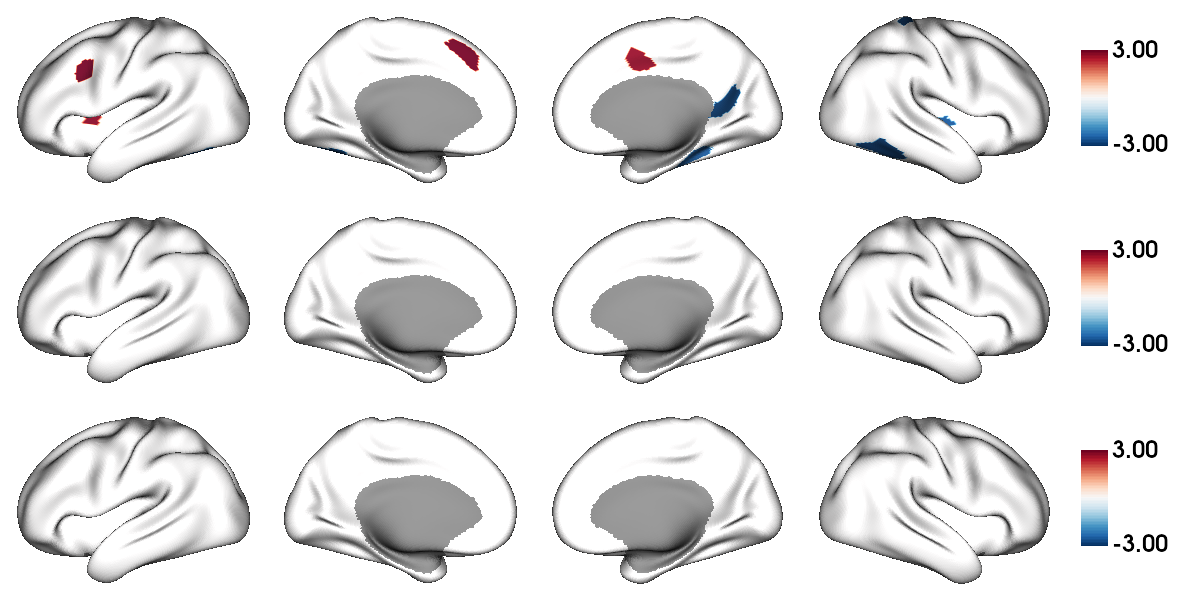

In [44]:
model = [None] * 400
for i in range(400):
  model[i] = smf.ols('node_'+str(i+1)+' ~ C(diagnosis2) + age + C(gender)', data=tmp_df).fit()
  # model[i] = OLS(tmp_df['node_'+str(i+1)], add_constant(tmp_df[['diagnosis2','age','gender']])).fit()

tmp = [np.array([model[i].tvalues['C(diagnosis2)[T.2]'] for i in range(400)]), 
       np.array([model[i].tvalues['age'] for i in range(400)]),
       np.array([model[i].tvalues['C(gender)[T.2]'] for i in range(400)])]

#tmp[0][fs.fdr(np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(400)]))>0.05] = 0
tmp[0][np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(400)]) > 0.01] = 0
tmp[1][fs.fdr(np.array([model[i].pvalues['age'] for i in range(400)]))>0.05] = 0
tmp[2][fs.fdr(np.array([model[i].pvalues['C(gender)[T.2]'] for i in range(400)]))>0.05] = 0

plot = [None] * len(tmp)
for i in range(len(tmp)):
  plot[i] = atlas.copy()
  for j in range(400):
    plot[i][atlas==j+1] = tmp[i][j]
  plot[i][atlas==0] = np.nan

fp.plot_surface(data=plot, size=(1200,200*len(tmp)), cmap='RdBu_r', color_range=(-3,3),
                display=True, filename='./figures/'+g_name+'_aligned_2groups_t.png')

In [45]:
model = [None] * 7
for i in range(7):
  model[i] = smf.ols('net_'+str(i+1)+' ~ C(diagnosis2) + age + C(gender)', data=net_df).fit()

tmp = [np.array([model[i].tvalues['C(diagnosis2)[T.2]'] for i in range(7)]), 
       np.array([model[i].tvalues['age'] for i in range(7)]),
       np.array([model[i].tvalues['C(gender)[T.2]'] for i in range(7)])]

#tmp[0][fs.fdr(np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(7)]))>0.05] = 0
#tmp[0][np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(7)])>0.01] = 0
#tmp[1][fs.fdr(np.array([model[i].pvalues['age'] for i in range(7)]))>0.05] = 0
#tmp[2][fs.fdr(np.array([model[i].pvalues['C(gender)[T.2]'] for i in range(7)]))>0.05] = 0
sts = pd.DataFrame()
sts['Network'] = net_name
sts['tvalue'] = np.array([model[i].tvalues['C(diagnosis2)[T.2]'] for i in range(7)])
sts['pvalue'] = np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(7)])
sts['pvalue_fdr'] = fs.fdr(np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(7)]))
sts.style.set_caption('G' + g_name+': CTR vs BD+SCZ')

/opt/miniconda3/envs/general/lib/python3.8/site-packages/brainspace/plotting/surface_plotting.py:437: RuntimeWarning: Running plot_hemispheres without a display may result in a crash. For a workaround please consult https://github.com/MICA-MNI/BrainSpace/issues/66. To suppress this warning set suppress_warnings=True.
  warnings.warn(


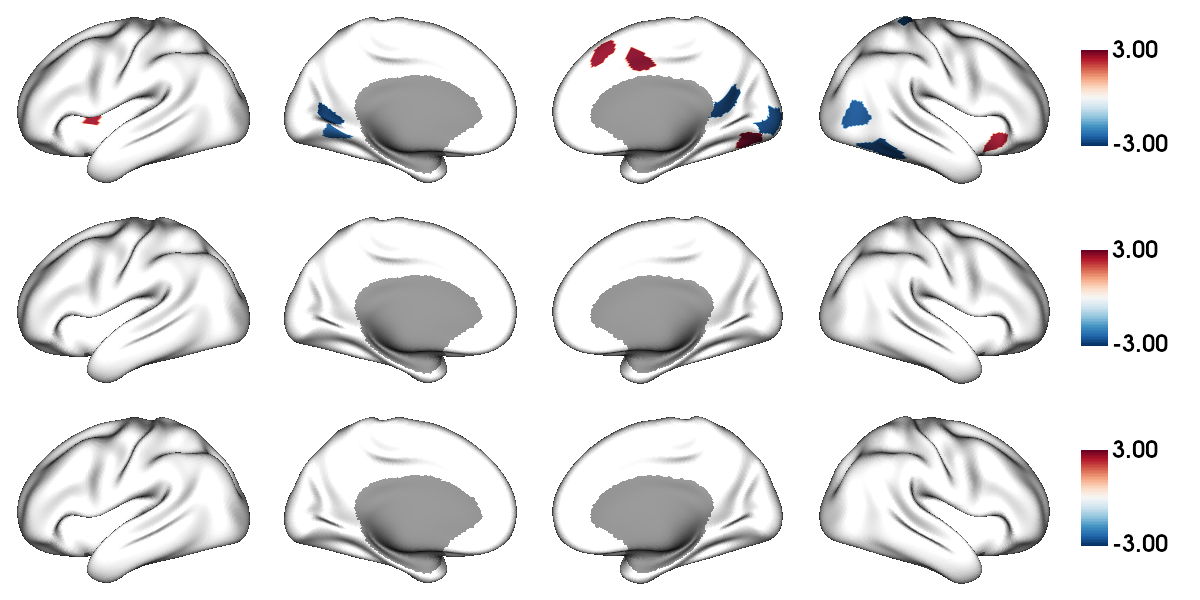

In [46]:
model = [None] * 400
for i in range(400):
  model[i] = smf.ols('node_'+str(i+1)+' ~ C(diagnosis) + age + C(gender)', data=tmp_df).fit()
  # model[i] = OLS(tmp_df['node_'+str(i+1)], add_constant(tmp_df[['diagnosis2','age','gender']])).fit()

tmp = [np.array([model[i].tvalues['C(diagnosis)[T.2]'] for i in range(400)]), 
       np.array([model[i].tvalues['age'] for i in range(400)]),
       np.array([model[i].tvalues['C(gender)[T.2]'] for i in range(400)])]

#tmp[0][fs.fdr(np.array([model[i].pvalues['C(diagnosis)[T.2]'] for i in range(400)]))>0.05] = 0
tmp[0][np.array([model[i].pvalues['C(diagnosis)[T.2]'] for i in range(400)])>0.01] = 0
tmp[1][fs.fdr(np.array([model[i].pvalues['age'] for i in range(400)]))>0.05] = 0
tmp[2][fs.fdr(np.array([model[i].pvalues['C(gender)[T.2]'] for i in range(400)]))>0.05] = 0

plot = [None] * len(tmp)
for i in range(len(tmp)):
  plot[i] = atlas.copy()
  for j in range(400):
    plot[i][atlas==j+1] = tmp[i][j]
  plot[i][atlas==0] = np.nan

fp.plot_surface(data=plot, size=(1200,200*len(tmp)), cmap='RdBu_r', color_range=(-3,3),
                display=True, filename='./figures/'+g_name+'_aligned_3groups_SCZ_t.png')

In [47]:
model = [None] * 7
for i in range(7):
  model[i] = smf.ols('net_'+str(i+1)+' ~ C(diagnosis) + age + C(gender)', data=net_df).fit()

tmp = [np.array([model[i].tvalues['C(diagnosis)[T.2]'] for i in range(7)]), 
       np.array([model[i].tvalues['age'] for i in range(7)]),
       np.array([model[i].tvalues['C(gender)[T.2]'] for i in range(7)])]

sts = pd.DataFrame()
sts['Network'] = net_name
sts['tvalue'] = np.array([model[i].tvalues['C(diagnosis)[T.2]'] for i in range(7)])
sts['pvalue'] = np.array([model[i].pvalues['C(diagnosis)[T.2]'] for i in range(7)])
sts['pvalue_fdr'] = fs.fdr(np.array([model[i].pvalues['C(diagnosis)[T.2]'] for i in range(7)]))
sts.style.set_caption('G' + g_name+': CTR vs SCZ')

/opt/miniconda3/envs/general/lib/python3.8/site-packages/brainspace/plotting/surface_plotting.py:437: RuntimeWarning: Running plot_hemispheres without a display may result in a crash. For a workaround please consult https://github.com/MICA-MNI/BrainSpace/issues/66. To suppress this warning set suppress_warnings=True.
  warnings.warn(


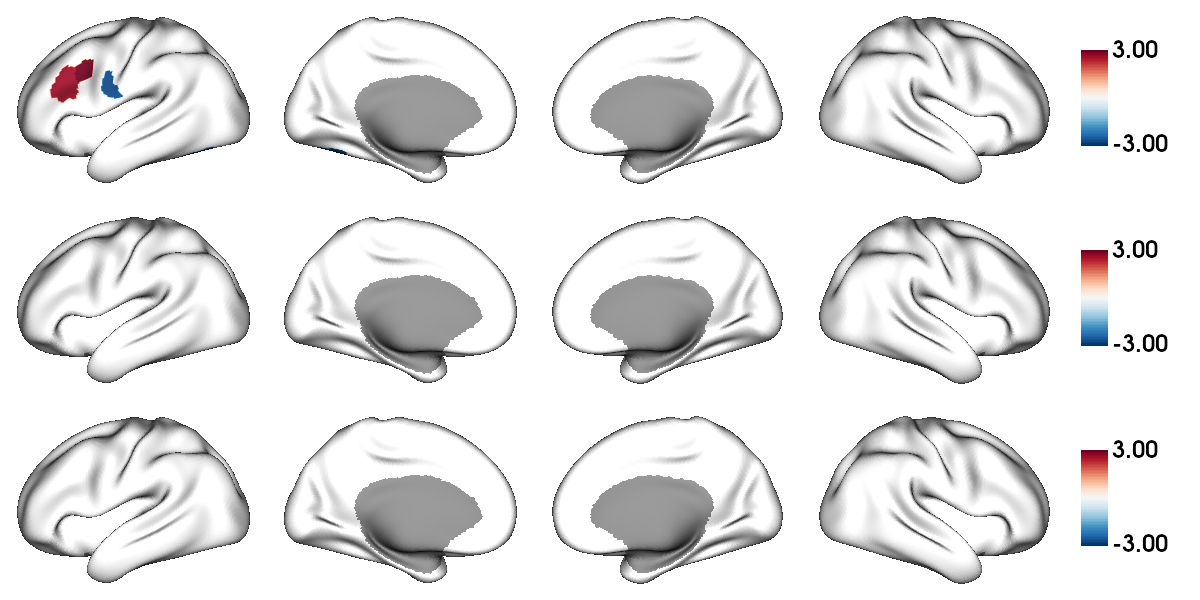

In [48]:
model = [None] * 400
for i in range(400):
  model[i] = smf.ols('node_'+str(i+1)+' ~ C(diagnosis) + age + C(gender)', data=tmp_df).fit()
  # model[i] = OLS(tmp_df['node_'+str(i+1)], add_constant(tmp_df[['diagnosis2','age','gender']])).fit()

tmp = [np.array([model[i].tvalues['C(diagnosis)[T.3]'] for i in range(400)]), 
       np.array([model[i].tvalues['age'] for i in range(400)]),
       np.array([model[i].tvalues['C(gender)[T.2]'] for i in range(400)])]

#tmp[0][fs.fdr(np.array([model[i].pvalues['C(diagnosis)[T.3]'] for i in range(400)]))>0.05] = 0
tmp[0][np.array([model[i].pvalues['C(diagnosis)[T.3]'] for i in range(400)])>0.01] = 0
tmp[1][fs.fdr(np.array([model[i].pvalues['age'] for i in range(400)]))>0.05] = 0
tmp[2][fs.fdr(np.array([model[i].pvalues['C(gender)[T.2]'] for i in range(400)]))>0.05] = 0

plot = [None] * len(tmp)
for i in range(len(tmp)):
  plot[i] = atlas.copy()
  for j in range(400):
    plot[i][atlas==j+1] = tmp[i][j]
  plot[i][atlas==0] = np.nan

fp.plot_surface(data=plot, size=(1200,200*len(tmp)), cmap='RdBu_r', color_range=(-3,3),
                display=True, filename='./figures/'+g_name+'_aligned_3groups_BD_t.png')

In [49]:
model = [None] * 7
for i in range(7):
  model[i] = smf.ols('net_'+str(i+1)+' ~ C(diagnosis) + age + C(gender)', data=net_df).fit()

tmp = [np.array([model[i].tvalues['C(diagnosis)[T.3]'] for i in range(7)]), 
       np.array([model[i].tvalues['age'] for i in range(7)]),
       np.array([model[i].tvalues['C(gender)[T.2]'] for i in range(7)])]

sts = pd.DataFrame()
sts['Network'] = net_name
sts['tvalue'] = np.array([model[i].tvalues['C(diagnosis)[T.3]'] for i in range(7)])
sts['pvalue'] = np.array([model[i].pvalues['C(diagnosis)[T.3]'] for i in range(7)])
sts['pvalue_fdr'] = fs.fdr(np.array([model[i].pvalues['C(diagnosis)[T.3]'] for i in range(7)]))
sts.style.set_caption("CTR vs BD")

In [50]:
sts = pd.DataFrame()
sts['Network'] = net_name
tmp = np.array([fs.pearson_na(net_df.hamilton_21, net_df['net_'+str(i+1)]) for i in range(7)])
sts['N'] = tmp[:,2].astype(int)
sts['Pearson r'] = tmp[:,0]
sts['pvalue'] = tmp[:,1]
sts.style.set_caption("hamilton_21")

In [51]:
sts = pd.DataFrame()
sts['Network'] = net_name
tmp = np.array([fs.pearson_na(net_df['SAPS Positive Symptoms'], net_df['net_'+str(i+1)]) for i in range(7)])
sts['N'] = tmp[:,2].astype(int)
sts['Pearson r'] = tmp[:,0]
sts['pvalue'] = tmp[:,1]
sts.style.set_caption("SAPS Positive Symptoms")

In [52]:
sts = pd.DataFrame()
sts['Network'] = net_name
tmp = np.array([fs.pearson_na(net_df['SAPS disorganization'], net_df['net_'+str(i+1)]) for i in range(7)])
sts['N'] = tmp[:,2].astype(int)
sts['Pearson r'] = tmp[:,0]
sts['pvalue'] = tmp[:,1]
sts.style.set_caption("SAPS disorganization")

In [53]:
sts = pd.DataFrame()
sts['Network'] = net_name
tmp = np.array([fs.pearson_na(net_df['Amotivation'], net_df['net_'+str(i+1)]) for i in range(7)])
sts['N'] = tmp[:,2].astype(int)
sts['Pearson r'] = tmp[:,0]
sts['pvalue'] = tmp[:,1]
sts.style.set_caption("Amotivation")

In [54]:
sts = pd.DataFrame()
sts['Network'] = net_name
tmp = np.array([fs.pearson_na(net_df['DimEx'], net_df['net_'+str(i+1)]) for i in range(7)])
sts['N'] = tmp[:,2].astype(int)
sts['Pearson r'] = tmp[:,0]
sts['pvalue'] = tmp[:,1]
sts.style.set_caption("DimEx")

## G3: p<0.01

In [55]:
g_n=2 #g2
g_name =str(g_n+1)
g = {}
g_net = {}
for i in grad.keys():
    g[i] = grad.get(i).aligned_[:,g_n] # change number here
    g_net[i] = np.zeros(7)
    for j in range(7):
        g_net[i][j] = grad.get(i).aligned_[network==j+1,g_n].mean()
tmp_df = pd.DataFrame.from_dict(g, orient='index')
tmp_df.columns = ['node_' +str(i+1) for i in range(400)]
tmp_df = tmp_df.rename_axis('participant_id').reset_index()
tmp_df = pd.merge(demo, tmp_df, on='participant_id')
tmp_df['diagnosis'] = tmp_df['diagnosis'].astype('category')
tmp_df['diagnosis2'] = tmp_df['diagnosis2'].astype('category')
tmp_df['gender'] = tmp_df['gender'].astype('category')
tmp_df

participant_id diagnosis  age gender  bart  bht  dwi  pamenc  pamret  \
0        sub-10159         1   30      2   1.0  NaN  1.0     NaN     NaN   
1        sub-10189         1   49      1   1.0  NaN  1.0     NaN     NaN   
2        sub-10206         1   21      1   1.0  NaN  1.0     NaN     NaN   
3        sub-10217         1   33      2   1.0  NaN  1.0     NaN     NaN   
4        sub-10225         1   35      1   1.0  1.0  1.0     NaN     NaN   
..             ...       ...  ...    ...   ...  ...  ...     ...     ...   
182      sub-60079         3   33      1   1.0  1.0  1.0     1.0     1.0   
183      sub-60080         3   29      1   1.0  1.0  1.0     1.0     1.0   
184      sub-60084         3   32      2   1.0  1.0  1.0     1.0     1.0   
185      sub-60087         3   41      1   1.0  1.0  1.0     1.0     1.0   
186      sub-60089         3   29      2   1.0  1.0  1.0     1.0     1.0   

     rest  ...  node_391  node_392  node_393  node_394  node_395  node_396  \
0     1.0  ... -0.376915 -0.323058 -0.368425 -0.379675 -0.138174  0.098387   
1     1.0  ...  0.398038  0.172892  0.339780  0.166322  0.101505  0.146838   
2     1.0  ... -0.427993 -0.468637 -0.433419 -0.431195 -0.435624 -0.398138   
3     1.0  ... -0.584523 -0.300844 -0.180283 -0.794724 -0.457460  0.022802   
4     1.0  ... -0.331805 -0.319458 -0.173299 -0.463027 -0.128038 -0.182142   
..    ...  ...       ...       ...       ...       ...       ...       ...   
182   1.0  ... -0.196807 -0.349412 -0.012585 -0.426468 -0.360293 -0.338718   
183   1.0  ... -0.574994 -0.580509 -0.337547 -0.591847 -0.420706 -0.350970   
184   1.0  ... -0.439401 -0.753637 -0.335996 -0.793876 -0.556187 -0.126393   
185   1.0  ...  0.354496  0.346733  0.340163 -0.208231  0.233413 -0.421858   
186   1.0  ...  0.180218 -0.174790  0.018875 -0.351872 -0.145836  0.283135   

     node_397  node_398  node_399  node_400  
0    0.038107 -0.090880 -0.116957  0.101976  
1    0.225248 -0.029637  0.183982  0.440565  
2   -0.043591 -0.368928 -0.253576 -0.461680  
3   -0.172761 -0.458038 -0.245267  0.411135  
4   -0.483086 -0.464912  0.569261  0.605141  
..        ...       ...       ...       ...  
182 -0.027256  0.199939 -0.259199  0.566653  
183 -0.475762 -0.217671  0.501955 -0.177661  
184  0.035352  0.240648 -0.776793 -0.332871  
185  0.189182 -0.057371 -0.197452  0.505721  
186 -0.012116 -0.135475  0.084123 -0.164719  

[187 rows x 426 columns]

In [56]:
net_df = pd.DataFrame.from_dict(g_net, orient='index')
net_df.columns = ['net_' +str(i+1) for i in range(7)]
net_df = net_df.rename_axis('participant_id').reset_index()
net_df = pd.merge(demo, net_df, on='participant_id')
net_df['diagnosis'] = net_df['diagnosis'].astype('category')
net_df['diagnosis2'] = net_df['diagnosis2'].astype('category')
net_df['gender'] = net_df['gender'].astype('category')
net_df

participant_id diagnosis  age gender  bart  bht  dwi  pamenc  pamret  \
0        sub-10159         1   30      2   1.0  NaN  1.0     NaN     NaN   
1        sub-10189         1   49      1   1.0  NaN  1.0     NaN     NaN   
2        sub-10206         1   21      1   1.0  NaN  1.0     NaN     NaN   
3        sub-10217         1   33      2   1.0  NaN  1.0     NaN     NaN   
4        sub-10225         1   35      1   1.0  1.0  1.0     NaN     NaN   
..             ...       ...  ...    ...   ...  ...  ...     ...     ...   
182      sub-60079         3   33      1   1.0  1.0  1.0     1.0     1.0   
183      sub-60080         3   29      1   1.0  1.0  1.0     1.0     1.0   
184      sub-60084         3   32      2   1.0  1.0  1.0     1.0     1.0   
185      sub-60087         3   41      1   1.0  1.0  1.0     1.0     1.0   
186      sub-60089         3   29      2   1.0  1.0  1.0     1.0     1.0   

     rest  ...  SAPS disorganization  hamilton_21  \
0     1.0  ...                   NaN          NaN   
1     1.0  ...                   NaN          NaN   
2     1.0  ...                   NaN          NaN   
3     1.0  ...                   NaN          NaN   
4     1.0  ...                   NaN          NaN   
..    ...  ...                   ...          ...   
182   1.0  ...                   1.0         27.0   
183   1.0  ...                   3.0         33.0   
184   1.0  ...                   2.0         26.0   
185   1.0  ...                   3.0          4.0   
186   1.0  ...                   3.0         18.0   

     Risperidone equivalent dose     net_1     net_2     net_3     net_4  \
0                            NaN -0.176798 -0.037254  0.415016  0.205989   
1                            NaN -0.197290 -0.152452  0.171269  0.200707   
2                            NaN -0.207531 -0.019922  0.504516  0.241151   
3                            NaN -0.268963 -0.231681  0.313496  0.250572   
4                            NaN -0.293627 -0.215814  0.320951  0.324863   
..                           ...       ...       ...       ...       ...   
182                         0.00 -0.254477  0.003490  0.511222  0.131397   
183                         1.67 -0.174462  0.045234  0.446408  0.238679   
184                        15.00 -0.293838 -0.160188  0.322084  0.333641   
185                         0.00 -0.155394 -0.115074  0.134286  0.090788   
186                         0.00 -0.029563 -0.100641  0.065415  0.065349   

        net_5     net_6     net_7  
0    0.114670 -0.005674 -0.195663  
1    0.221326  0.203445 -0.108481  
2    0.166833  0.081247 -0.317702  
3    0.239052  0.267696 -0.132825  
4    0.232347  0.267590 -0.169880  
..        ...       ...       ...  
182  0.369406  0.114646 -0.329711  
183  0.163207 -0.054135 -0.285954  
184  0.405595  0.265209 -0.270052  
185  0.304374  0.163656 -0.093718  
186  0.105351  0.082074 -0.038843  

[187 rows x 33 columns]

/opt/miniconda3/envs/general/lib/python3.8/site-packages/brainspace/plotting/surface_plotting.py:437: RuntimeWarning: Running plot_hemispheres without a display may result in a crash. For a workaround please consult https://github.com/MICA-MNI/BrainSpace/issues/66. To suppress this warning set suppress_warnings=True.
  warnings.warn(


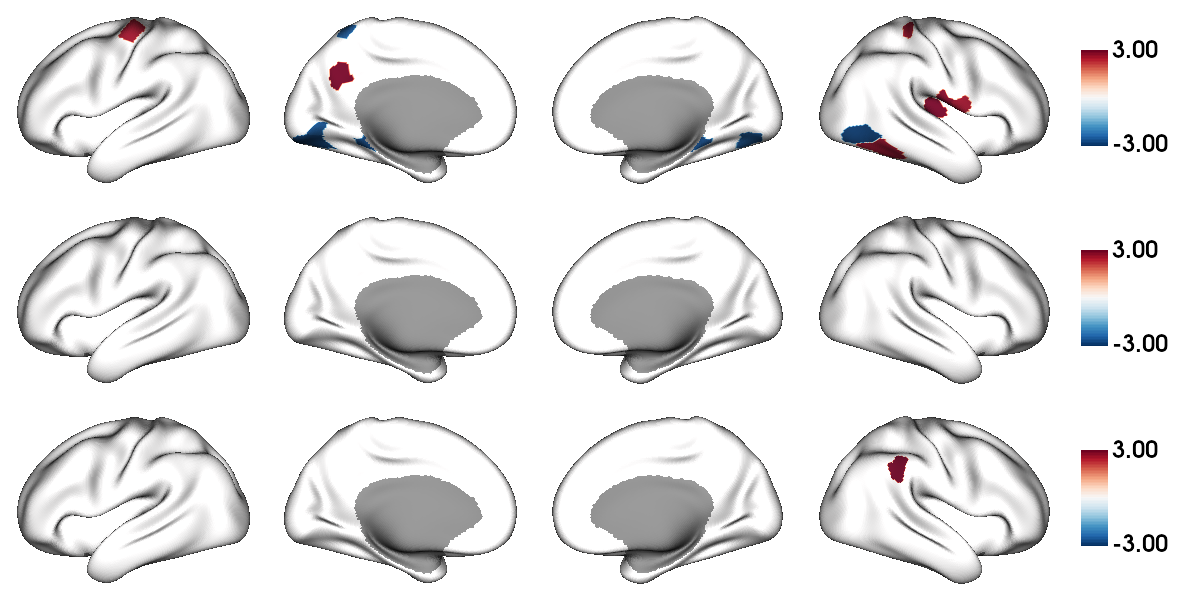

In [57]:
model = [None] * 400
for i in range(400):
  model[i] = smf.ols('node_'+str(i+1)+' ~ C(diagnosis2) + age + C(gender)', data=tmp_df).fit()
  # model[i] = OLS(tmp_df['node_'+str(i+1)], add_constant(tmp_df[['diagnosis2','age','gender']])).fit()

tmp = [np.array([model[i].tvalues['C(diagnosis2)[T.2]'] for i in range(400)]), 
       np.array([model[i].tvalues['age'] for i in range(400)]),
       np.array([model[i].tvalues['C(gender)[T.2]'] for i in range(400)])]

#tmp[0][fs.fdr(np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(400)]))>0.05] = 0
tmp[0][np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(400)]) > 0.01] = 0
tmp[1][fs.fdr(np.array([model[i].pvalues['age'] for i in range(400)]))>0.05] = 0
tmp[2][fs.fdr(np.array([model[i].pvalues['C(gender)[T.2]'] for i in range(400)]))>0.05] = 0

plot = [None] * len(tmp)
for i in range(len(tmp)):
  plot[i] = atlas.copy()
  for j in range(400):
    plot[i][atlas==j+1] = tmp[i][j]
  plot[i][atlas==0] = np.nan

fp.plot_surface(data=plot, size=(1200,200*len(tmp)), cmap='RdBu_r', color_range=(-3,3),
                display=True, filename='./figures/'+g_name+'_aligned_2groups_t.png')

In [58]:
model = [None] * 7
for i in range(7):
  model[i] = smf.ols('net_'+str(i+1)+' ~ C(diagnosis2) + age + C(gender)', data=net_df).fit()

tmp = [np.array([model[i].tvalues['C(diagnosis2)[T.2]'] for i in range(7)]), 
       np.array([model[i].tvalues['age'] for i in range(7)]),
       np.array([model[i].tvalues['C(gender)[T.2]'] for i in range(7)])]

#tmp[0][fs.fdr(np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(7)]))>0.05] = 0
#tmp[0][np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(7)])>0.01] = 0
#tmp[1][fs.fdr(np.array([model[i].pvalues['age'] for i in range(7)]))>0.05] = 0
#tmp[2][fs.fdr(np.array([model[i].pvalues['C(gender)[T.2]'] for i in range(7)]))>0.05] = 0
sts = pd.DataFrame()
sts['Network'] = net_name
sts['tvalue'] = np.array([model[i].tvalues['C(diagnosis2)[T.2]'] for i in range(7)])
sts['pvalue'] = np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(7)])
sts['pvalue_fdr'] = fs.fdr(np.array([model[i].pvalues['C(diagnosis2)[T.2]'] for i in range(7)]))
sts.style.set_caption('G' + g_name+': CTR vs BD+SCZ')

/opt/miniconda3/envs/general/lib/python3.8/site-packages/brainspace/plotting/surface_plotting.py:437: RuntimeWarning: Running plot_hemispheres without a display may result in a crash. For a workaround please consult https://github.com/MICA-MNI/BrainSpace/issues/66. To suppress this warning set suppress_warnings=True.
  warnings.warn(


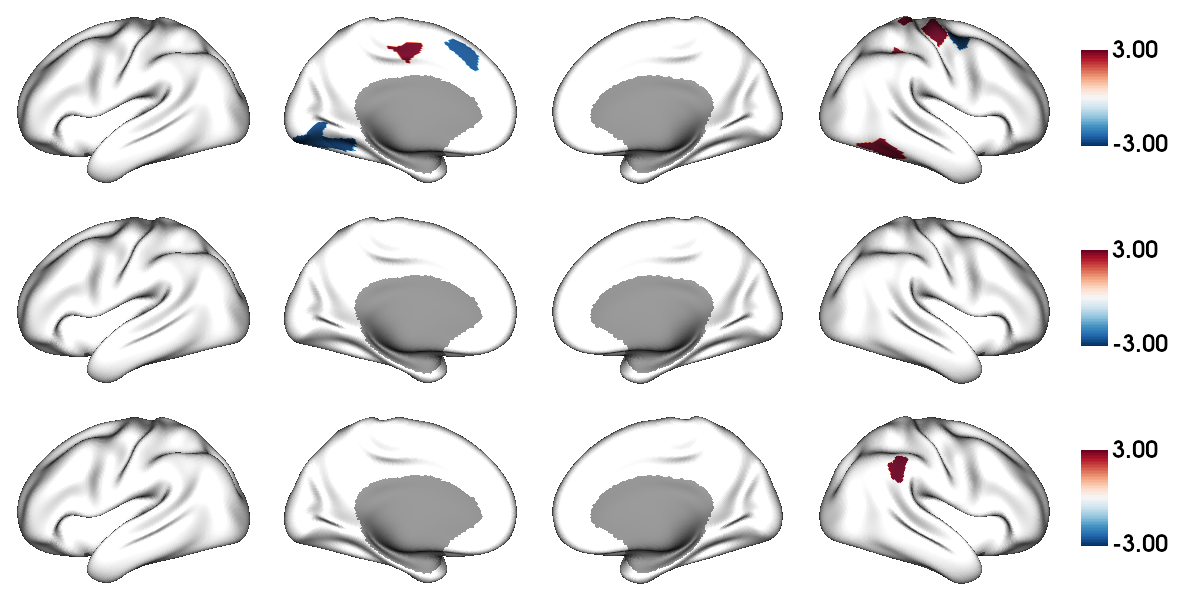

In [59]:
model = [None] * 400
for i in range(400):
  model[i] = smf.ols('node_'+str(i+1)+' ~ C(diagnosis) + age + C(gender)', data=tmp_df).fit()
  # model[i] = OLS(tmp_df['node_'+str(i+1)], add_constant(tmp_df[['diagnosis2','age','gender']])).fit()

tmp = [np.array([model[i].tvalues['C(diagnosis)[T.2]'] for i in range(400)]), 
       np.array([model[i].tvalues['age'] for i in range(400)]),
       np.array([model[i].tvalues['C(gender)[T.2]'] for i in range(400)])]

#tmp[0][fs.fdr(np.array([model[i].pvalues['C(diagnosis)[T.2]'] for i in range(400)]))>0.05] = 0
tmp[0][np.array([model[i].pvalues['C(diagnosis)[T.2]'] for i in range(400)])>0.01] = 0
tmp[1][fs.fdr(np.array([model[i].pvalues['age'] for i in range(400)]))>0.05] = 0
tmp[2][fs.fdr(np.array([model[i].pvalues['C(gender)[T.2]'] for i in range(400)]))>0.05] = 0

plot = [None] * len(tmp)
for i in range(len(tmp)):
  plot[i] = atlas.copy()
  for j in range(400):
    plot[i][atlas==j+1] = tmp[i][j]
  plot[i][atlas==0] = np.nan

fp.plot_surface(data=plot, size=(1200,200*len(tmp)), cmap='RdBu_r', color_range=(-3,3),
                display=True, filename='./figures/'+g_name+'_aligned_3groups_SCZ_t.png')

In [60]:
model = [None] * 7
for i in range(7):
  model[i] = smf.ols('net_'+str(i+1)+' ~ C(diagnosis) + age + C(gender)', data=net_df).fit()

tmp = [np.array([model[i].tvalues['C(diagnosis)[T.2]'] for i in range(7)]), 
       np.array([model[i].tvalues['age'] for i in range(7)]),
       np.array([model[i].tvalues['C(gender)[T.2]'] for i in range(7)])]

sts = pd.DataFrame()
sts['Network'] = net_name
sts['tvalue'] = np.array([model[i].tvalues['C(diagnosis)[T.2]'] for i in range(7)])
sts['pvalue'] = np.array([model[i].pvalues['C(diagnosis)[T.2]'] for i in range(7)])
sts['pvalue_fdr'] = fs.fdr(np.array([model[i].pvalues['C(diagnosis)[T.2]'] for i in range(7)]))
sts.style.set_caption('G' + g_name+': CTR vs SCZ')

/opt/miniconda3/envs/general/lib/python3.8/site-packages/brainspace/plotting/surface_plotting.py:437: RuntimeWarning: Running plot_hemispheres without a display may result in a crash. For a workaround please consult https://github.com/MICA-MNI/BrainSpace/issues/66. To suppress this warning set suppress_warnings=True.
  warnings.warn(


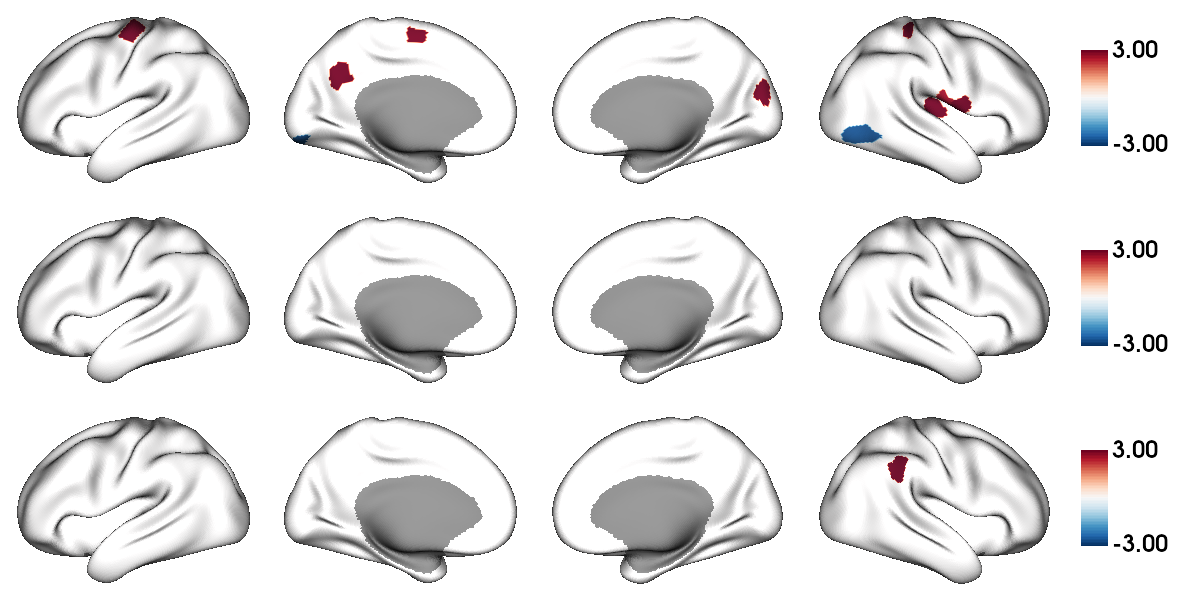

In [61]:
model = [None] * 400
for i in range(400):
  model[i] = smf.ols('node_'+str(i+1)+' ~ C(diagnosis) + age + C(gender)', data=tmp_df).fit()
  # model[i] = OLS(tmp_df['node_'+str(i+1)], add_constant(tmp_df[['diagnosis2','age','gender']])).fit()

tmp = [np.array([model[i].tvalues['C(diagnosis)[T.3]'] for i in range(400)]), 
       np.array([model[i].tvalues['age'] for i in range(400)]),
       np.array([model[i].tvalues['C(gender)[T.2]'] for i in range(400)])]

#tmp[0][fs.fdr(np.array([model[i].pvalues['C(diagnosis)[T.3]'] for i in range(400)]))>0.05] = 0
tmp[0][np.array([model[i].pvalues['C(diagnosis)[T.3]'] for i in range(400)])>0.01] = 0
tmp[1][fs.fdr(np.array([model[i].pvalues['age'] for i in range(400)]))>0.05] = 0
tmp[2][fs.fdr(np.array([model[i].pvalues['C(gender)[T.2]'] for i in range(400)]))>0.05] = 0

plot = [None] * len(tmp)
for i in range(len(tmp)):
  plot[i] = atlas.copy()
  for j in range(400):
    plot[i][atlas==j+1] = tmp[i][j]
  plot[i][atlas==0] = np.nan

fp.plot_surface(data=plot, size=(1200,200*len(tmp)), cmap='RdBu_r', color_range=(-3,3),
                display=True, filename='./figures/'+g_name+'_aligned_3groups_BD_t.png')

In [62]:
model = [None] * 7
for i in range(7):
  model[i] = smf.ols('net_'+str(i+1)+' ~ C(diagnosis) + age + C(gender)', data=net_df).fit()

tmp = [np.array([model[i].tvalues['C(diagnosis)[T.3]'] for i in range(7)]), 
       np.array([model[i].tvalues['age'] for i in range(7)]),
       np.array([model[i].tvalues['C(gender)[T.2]'] for i in range(7)])]

sts = pd.DataFrame()
sts['Network'] = net_name
sts['tvalue'] = np.array([model[i].tvalues['C(diagnosis)[T.3]'] for i in range(7)])
sts['pvalue'] = np.array([model[i].pvalues['C(diagnosis)[T.3]'] for i in range(7)])
sts['pvalue_fdr'] = fs.fdr(np.array([model[i].pvalues['C(diagnosis)[T.3]'] for i in range(7)]))
sts.style.set_caption("CTR vs BD")

In [63]:
sts = pd.DataFrame()
sts['Network'] = net_name
tmp = np.array([fs.pearson_na(net_df.hamilton_21, net_df['net_'+str(i+1)]) for i in range(7)])
sts['N'] = tmp[:,2].astype(int)
sts['Pearson r'] = tmp[:,0]
sts['pvalue'] = tmp[:,1]
sts.style.set_caption("hamilton_21")

In [64]:
sts = pd.DataFrame()
sts['Network'] = net_name
tmp = np.array([fs.pearson_na(net_df['SAPS Positive Symptoms'], net_df['net_'+str(i+1)]) for i in range(7)])
sts['N'] = tmp[:,2].astype(int)
sts['Pearson r'] = tmp[:,0]
sts['pvalue'] = tmp[:,1]
sts.style.set_caption("SAPS Positive Symptoms")

In [65]:
sts = pd.DataFrame()
sts['Network'] = net_name
tmp = np.array([fs.pearson_na(net_df['SAPS disorganization'], net_df['net_'+str(i+1)]) for i in range(7)])
sts['N'] = tmp[:,2].astype(int)
sts['Pearson r'] = tmp[:,0]
sts['pvalue'] = tmp[:,1]
sts.style.set_caption("SAPS disorganization")

In [66]:
sts = pd.DataFrame()
sts['Network'] = net_name
tmp = np.array([fs.pearson_na(net_df['Amotivation'], net_df['net_'+str(i+1)]) for i in range(7)])
sts['N'] = tmp[:,2].astype(int)
sts['Pearson r'] = tmp[:,0]
sts['pvalue'] = tmp[:,1]
sts.style.set_caption("Amotivation")

In [67]:
sts = pd.DataFrame()
sts['Network'] = net_name
tmp = np.array([fs.pearson_na(net_df['DimEx'], net_df['net_'+str(i+1)]) for i in range(7)])
sts['N'] = tmp[:,2].astype(int)
sts['Pearson r'] = tmp[:,0]
sts['pvalue'] = tmp[:,1]
sts.style.set_caption("DimEx")

## End